In [1]:
%run ./check_DOVS_METHODS.ipynb

In [2]:
from importlib import reload
#reload(Utilities)
#reload(clm)

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns
from packaging import version

import copy

import itertools

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
from DOVSAudit import DOVSAudit
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
from Utilities_df import DFConstructType
import Plot_General
import Plot_Box_sns
import Plot_Hist
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer

# Analyze collected data

## AMI NonVee

In [ ]:
# base_dir_ami = r'C:\Users\s346557\Documents\LocalData\dovs_check\AMINonVee'
# base_dir_ede = r'C:\Users\s346557\Documents\LocalData\dovs_check\EndEvents'
# save_dir     = r'C:\Users\s346557\Documents\LocalData\dovs_check\Results'

# base_dir_ami = r'C:\Users\s346557\Documents\LocalData\dovs_check\forAmanda\SN_882735506\AMINonVee'
# base_dir_ede = r'C:\Users\s346557\Documents\LocalData\dovs_check\forAmanda\SN_882735506\EndEvents'
# save_dir     = r'C:\Users\s346557\Documents\LocalData\dovs_check\forAmanda\SN_882735506\Results'

# base_dir_ami = r'C:\Users\s346557\Documents\LocalData\dovs_check\ByOPCO\swp\AMINonVee'
# base_dir_ede = r'C:\Users\s346557\Documents\LocalData\dovs_check\ByOPCO\swp\EndEvents'
# save_dir     = r'C:\Users\s346557\Documents\LocalData\dovs_check\ByOPCO\swp\Results'

# base_dir_ami = r'C:\Users\s346557\Documents\LocalData\dovs_check\20230806_20230812\AllOPCOs\AMINonVee'
# base_dir_ede = r'C:\Users\s346557\Documents\LocalData\dovs_check\20230806_20230812\AllOPCOs\EndEvents'
# save_dir     = r'C:\Users\s346557\Documents\LocalData\dovs_check\20230806_20230812\AllOPCOs\Results'

base_dir_ami = r'C:\Users\s346557\Documents\LocalData\dovs_check\FirstResults\AMINonVee'
base_dir_ede = r'C:\Users\s346557\Documents\LocalData\dovs_check\FirstResults\EndEvents'
save_dir     = r'C:\Users\s346557\Documents\LocalData\dovs_check\FirstResults\Results'

In [ ]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
#-------------------------
paths = Utilities.find_all_paths(
    base_dir=base_dir_ami, 
    glob_pattern=r'ami_nonvee_[0-9]*.csv', 
    regex_pattern=None
)
paths=natsorted(paths)
#-------------------------
outg_rec_nbs_in_files = dict()
for path in paths:
    assert(path not in outg_rec_nbs_in_files.keys())
    df = GenAn.read_df_from_csv(path)
    outg_rec_nbs_in_files[path] = df['OUTG_REC_NB_GPD_FOR_SQL'].unique().tolist()
outg_rec_nb_to_files_dict = invert_file_to_outg_rec_nbs_dict(outg_rec_nbs_in_files)
all_outg_rec_nbs = list(outg_rec_nb_to_files_dict.keys())

In [ ]:
#-------------------------
paths_ede = Utilities.find_all_paths(
    base_dir=base_dir_ede, 
    glob_pattern=r'end_events_[0-9]*.csv', 
    regex_pattern=None
)
paths_ede=natsorted(paths_ede)
#-------------------------
outg_rec_nbs_in_files_ede = dict()
for path in paths_ede:
    assert(path not in outg_rec_nbs_in_files_ede.keys())
    df = GenAn.read_df_from_csv(path)
    outg_rec_nbs_in_files_ede[path] = df['OUTG_REC_NB_GPD_FOR_SQL'].unique().tolist()
outg_rec_nb_to_files_ede_dict = invert_file_to_outg_rec_nbs_dict(outg_rec_nbs_in_files_ede)
all_outg_rec_nbs_ede = list(outg_rec_nb_to_files_ede_dict.keys())

In [ ]:
#-------------------------
instvabc_slcr = DFSlicer(
    single_slicers = [
        dict(
            column='aep_derived_uom', 
            value='VOLT', 
            comparison_operator='=='
        ), 
        dict(
            column='aep_srvc_qlty_idntfr', 
            value=['INSTVA1', 'INSTVB1', 'INSTVC1'], 
            comparison_operator='isin'
        )
    ], 
    name='VOLT, INSTV(ABC)1', 
    join_single_slicers='and'
)
#-------------------------
volt_avg_slcr = DFSlicer(
    single_slicers = [
        dict(
            column='aep_derived_uom', 
            value='VOLT', 
            comparison_operator='=='
        ), 
        dict(
            column='aep_srvc_qlty_idntfr', 
            value='AVG', 
            comparison_operator='=='
        )
    ], 
    name='VOLT, AVG', 
    join_single_slicers='and'
)
#-------------------------
slicers=[instvabc_slcr, volt_avg_slcr]

In [ ]:
# start = time.time()
# outg_rec_nbs_to_remove = identify_outg_rec_nbs_to_remove(
#     paths=paths,
#     slicers=slicers, 
#     verbose=True
# )
# print(time.time()-start)

In [ ]:
# outg_rec_nbs_to_remove=[]

In [ ]:
include_suboutg_endpt_plots=True

calculate_by_PN = True
# combine_by_PN_likeness_thresh = pd.Timedelta('1 minutes')
combine_by_PN_likeness_thresh = pd.Timedelta('15 minutes')

expand_outg_search_time_tight = pd.Timedelta('1 hours')
expand_outg_search_time_loose = pd.Timedelta('12 hours')
use_est_outg_times=False
use_full_ede_outgs=False
run_outg_inclusion_assessment=True
max_pct_PNs_missing_allowed=0
# max_pct_PNs_missing_allowed=20
#-----
expand_outg_est_search_time = expand_outg_search_time_loose
if use_est_outg_times:
    expand_outg_search_time = expand_outg_search_time_tight
else:
    expand_outg_search_time = expand_outg_search_time_loose

In [ ]:
pdf_path = os.path.join(save_dir, r'Results.pdf')
pdf = PdfPages(pdf_path)
#-------------------------
pdf_path_dovs_beg = Utilities.append_to_path(
    pdf_path, 
    '_dovs_beg', 
    ext_to_find='.pdf', 
    append_to_end_if_ext_no_found=False
)
pdf_dovs_beg = PdfPages(pdf_path_dovs_beg)
#-------------------------
if include_suboutg_endpt_plots:
    pdf_path_2 = Utilities.append_to_path(
        pdf_path, 
        '_w_suboutg_endpt_plots', 
        ext_to_find='.pdf', 
        append_to_end_if_ext_no_found=False
    )
    pdf_2 = PdfPages(pdf_path_2)

In [ ]:
fig_num=0
all_detailed_summary_dfs=[]
all_detailed_summary_dfs_dovs_beg=[]
ci_cmi_summary_df = pd.DataFrame(columns=[
    'outg_rec_nb', 
    'ci_dovs',  'ci_ami', 'ci_ami_dovs_beg', 
    'cmi_dovs', 'cmi_ami', 'cmi_ami_dovs_beg'
])

#-------------------------
# Build dovs_df
dovs = DOVSOutages(
    df_construct_type=DFConstructType.kRunSqlQuery, 
    contstruct_df_args=None, 
    init_df_in_constructor=True,
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
    build_sql_function_kwargs=dict(
        outg_rec_nbs=all_outg_rec_nbs, 
        field_to_split='outg_rec_nbs', 
        include_premise=True
    ), 
    build_consolidated=True
)
dovs_df = dovs.df.copy()

#-------------------------
# Now, iterate through all outages
for i_outg, outg_rec_nb in enumerate(all_outg_rec_nbs):
    print(f'\n\ti_outg: {i_outg+1}/{len(all_outg_rec_nbs)}')
    print(f'\toutg_rec_nb = {outg_rec_nb}')
    #-----
    ami_df = GenAn.read_df_from_csv_batch(outg_rec_nb_to_files_dict[outg_rec_nb])
    #--------------------------------------------------
    ami_df_i = ami_df[ami_df['OUTG_REC_NB_GPD_FOR_SQL']==outg_rec_nb].copy()
    
    # Although I cannot yet call choose_best_slicer_and_perform_slicing and reduce_INSTV_ABC_1_vals_in_df, 
    #   as the standard cleaning and conversions must be done first, I am able to cut down the size of
    #   ami_df_i by joining the slicers with 'or' statements.
    # Thus, ami_df_i will be reduced to only the subset of data which will be considered in 
    #   choose_best_slicer_and_perform_slicing
    # As mentioned, this will cut down the size of ami_df_i and will also save time and resources by not having
    #   to run entire DF through cleaning and conversions procedures.
    ami_df_i = DFSlicer.combine_slicers_and_perform_slicing(
        df=ami_df_i, 
        slicers=slicers, 
        join_slicers='or'
    )
    if ami_df_i.shape[0]==0:
        continue
        
    #--------------------------------------------------
    ami_df_i = AMINonVee.perform_std_initiation_and_cleaning(ami_df_i)
    #-----
    # Should the following be added to AMINonVee.perform_std_initiation_and_cleaning?
    ami_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
        df=ami_df_i, 
        time_col='starttimeperiod', 
        placement_col='starttimeperiod_local', 
        run_quick=True, 
        n_strip=6, 
        inplace=False
    )
    ami_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
        df=ami_df_i, 
        time_col='endtimeperiod', 
        placement_col='endtimeperiod_local', 
        run_quick=True, 
        n_strip=6, 
        inplace=False
    )
    #--------------------------------------------------
    ami_df_i = choose_best_slicer_and_perform_slicing(
        df=ami_df_i, 
        slicers=slicers, 
        groupby_SN=True, 
        t_search_min_max=None, 
        time_col='starttimeperiod_local', 
        value_col=None, 
        SN_col='serialnumber', 
        return_sorted=True
    )

    ami_df_i = reduce_INSTV_ABC_1_vals_in_df(
        df=ami_df_i, 
        value_col='value', 
        aep_derived_uom_col='aep_derived_uom', 
        aep_srvc_qlty_idntfr_col='aep_srvc_qlty_idntfr', 
        output_aep_srvc_qlty_idntfr = 'INSTV(ABC)1'
    )

    if ami_df_i.shape[0]==0:
        continue
        
    #-------------------------
    # Each serial number should have a single value per time stamp
    assert(ami_df_i.groupby(['serialnumber', 'starttimeperiod_local']).ngroups == ami_df_i.shape[0])

    #-------------------------
    if run_outg_inclusion_assessment:
        to_include_i = assess_outage_inclusion_requirements(
            ami_df_i=ami_df_i, 
            outg_rec_nb=outg_rec_nb, 
            dovs_df=dovs_df, 
            max_pct_PNs_missing_allowed=max_pct_PNs_missing_allowed

        )
        if not to_include_i:
            print(f'outg_rec_nb={outg_rec_nb} did not pass inclusion requirements, skipping!!!!!')
            continue
    #-------------------------    
    n_SNs  = ami_df_i['serialnumber'].nunique()
    n_PNs  = ami_df_i['aep_premise_nb'].nunique()
    
    #----------------------------------------------------------------------------------------------------
    # NOTE: Can save time by grabbing ede_df_i then performing tz conversion and adding DOVS
    if outg_rec_nb not in outg_rec_nb_to_files_ede_dict.keys():
        ede_df_i=None
    else:
        ede_df = GenAn.read_df_from_csv_batch(outg_rec_nb_to_files_ede_dict[outg_rec_nb])
        ede_df_i = ede_df[ede_df['OUTG_REC_NB_GPD_FOR_SQL']==outg_rec_nb].copy()

        #-----
        ede_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
            df=ede_df_i, 
            time_col='valuesinterval', 
            placement_col='valuesinterval_local', 
            run_quick=True, 
            n_strip=6, 
            inplace=False
        )
        ede_df_i = AMIEndEvents.reduce_end_event_reasons_in_df(df=ede_df_i)
        #-----
        ede_cols_to_keep = [
            'valuesinterval_local', 
            'reason', 
            'serialnumber', 
            'aep_premise_nb', 
            'enddeviceeventtypeid', 
            'event_type', 
            'OUTG_REC_NB_GPD_FOR_SQL', 
            'trsf_pole_nb_GPD_FOR_SQL',
        ]
        ede_df_i = ede_df_i[ede_cols_to_keep]
        
    #----------------------------------------------------------------------------------------------------
    dovs_df_i = DOVSOutages.retrieve_outage_from_dovs_df(
        dovs_df=dovs_df, 
        outg_rec_nb=outg_rec_nb, 
        outg_rec_nb_idfr='index', 
        assert_outg_rec_nb_found=True
    )
    assert(dovs_df_i.shape[0]==1)
    # Get the outage time from DOVS
    dovs_outg_t_beg_end = dovs_df_i.iloc[0][['DT_OFF_TS_FULL', 'DT_ON_TS']].tolist()
    assert(len(dovs_outg_t_beg_end)==2)
    dovs_outg_t_beg, dovs_outg_t_end = dovs_outg_t_beg_end
    #-------------------------
    # Get the CI and CMI from DOVS
    ci_cmi_dovs = dovs_df_i.iloc[0][['CI_NB', 'CMI_NB']].tolist()
    assert(len(ci_cmi_dovs)==2)
    ci_dovs, cmi_dovs = ci_cmi_dovs
    #-------------------------
    # Get the number of premises from DOVS
    n_PNs_dovs = len(set(dovs_df_i.iloc[0]['premise_nbs']))
    #-------------------------
    # Get the outage number from DOVS
    outage_nb = dovs_df_i.iloc[0]['OUTAGE_NB']
    
    #--------------------------------------------------
    res_dict = calculate_ci_cmi_w_ami_w_ede_help(
        df=ami_df_i, 
        ede_df=ede_df_i, 
        dovs_outg_t_beg_end=dovs_outg_t_beg_end, 
        expand_outg_search_time=expand_outg_search_time, 
        conservative_estimate=True, 
        est_ede_kwargs=dict(use_full_ede_outgs=use_full_ede_outgs), 
        audit_selection_method='ede only', 
        return_CI_SNs=False, 
        use_est_outg_times=use_est_outg_times, 
        pct_SNs_required_for_outage_est=0, 
        expand_outg_est_search_time=expand_outg_est_search_time, 
        use_only_overall_endpoints_of_est_outg_times=False, 
        t_int_beg_col='starttimeperiod_local', 
        t_int_end_col='endtimeperiod_local', 
        value_col='value', 
        SN_col='serialnumber', 
        return_all_best_ests=True, 
        return_all_best_ests_type='pd.DataFrame'
    )
    #-----
    ci_ami       = res_dict['CI']
    cmi_ami      = res_dict['CMI']
    best_ests_df = res_dict['all_best_ests']
    #--------------------------------------------------
    if calculate_by_PN and best_ests_df.shape[0]>0:
        try:
            best_ests_df = combine_PNs_in_best_ests_df(
                best_ests_df, 
                likeness_thresh = combine_by_PN_likeness_thresh, 
                SN_col = 'SN', 
                PN_col = 'PN', 
                i_outg_col = 'i_outg'     
            )
            ci_ami  = best_ests_df['PN'].nunique()
            cmi_ami = (best_ests_df['winner_max']-best_ests_df['winner_min']).sum().total_seconds()/60
        except:
            print(f'outg_rec_nb={outg_rec_nb} failed combine_PNs_in_best_ests_df, so skipping')
            continue
    #--------------------------------------------------
    if best_ests_df.shape[0]>0:
        best_ests_df_dovs_beg = alter_best_ests_df_using_dovs_outg_t_beg(
            best_ests_df=best_ests_df,
            dovs_df=dovs_df_i, 
            outg_rec_nb=outg_rec_nb
        )
        if calculate_by_PN:
            ci_ami_dovs_beg  = best_ests_df_dovs_beg['PN'].nunique()
        else:
            ci_ami_dovs_beg  = best_ests_df_dovs_beg['SN'].nunique()
        cmi_ami_dovs_beg = (best_ests_df_dovs_beg['winner_max']-best_ests_df_dovs_beg['winner_min']).sum().total_seconds()/60
    else:
        best_ests_df_dovs_beg = best_ests_df.copy()
        ci_ami_dovs_beg = ci_ami
        cmi_ami_dovs_beg = cmi_ami        
    #--------------------------------------------------
    if best_ests_df.shape[0]>0:
        means_df, best_ests_df_w_db_lbl = get_mean_times_w_dbscan(
            best_ests_df, 
            eps_min=5, 
            min_samples=2, 
            ests_to_include_in_clustering=['winner_min', 'winner_max'],
            ests_to_include_in_output=[
                'winner_min', 'winner_max', 
                'conservative_min', 'conservative_max', 
                'zero_times_min', 'zero_times_max'
            ], 
            return_labelled_best_ests_df=True
        )
        #-----
        detailed_summary_df_i = build_detailed_summary_df(
            means_df=means_df, 
            best_ests_df_w_db_lbl=best_ests_df_w_db_lbl,
            CI_tot=ci_ami, 
            CMI_tot=cmi_ami, 
            n_PNs_ami=n_PNs,
            outg_rec_nb=outg_rec_nb, 
            dovs_df_i=dovs_df_i, 
            db_label_col='db_label', 
            winner_min_col='winner_min', 
            winner_max_col='winner_max', 
            PN_col='PN' if calculate_by_PN else 'SN', 
            i_outg_col='i_outg'
        )
        all_detailed_summary_dfs.append(detailed_summary_df_i)
    else:
        means_df, best_ests_df_w_db_lbl = None, None
    #--------------------------------------------------
    if best_ests_df_dovs_beg.shape[0]>0:
        means_df_dovs_beg, best_ests_df_dovs_beg_w_db_lbl = get_mean_times_w_dbscan(
            best_ests_df_dovs_beg, 
            eps_min=5, 
            min_samples=2, 
            ests_to_include_in_clustering=['winner_min', 'winner_max'],
            ests_to_include_in_output=[
                'winner_min', 'winner_max', 
                'conservative_min', 'conservative_max', 
                'zero_times_min', 'zero_times_max'
            ], 
            return_labelled_best_ests_df=True
        )
        #-----
        detailed_summary_df_dovs_beg_i = build_detailed_summary_df(
            means_df=means_df_dovs_beg, 
            best_ests_df_w_db_lbl=best_ests_df_dovs_beg_w_db_lbl,
            CI_tot=ci_ami_dovs_beg, 
            CMI_tot=cmi_ami_dovs_beg, 
            n_PNs_ami=n_PNs,
            outg_rec_nb=outg_rec_nb, 
            dovs_df_i=dovs_df_i, 
            db_label_col='db_label', 
            winner_min_col='winner_min', 
            winner_max_col='winner_max', 
            PN_col='PN' if calculate_by_PN else 'SN', 
            i_outg_col='i_outg'
        )
        all_detailed_summary_dfs_dovs_beg.append(detailed_summary_df_dovs_beg_i)
    else:
        means_df_dovs_beg, best_ests_df_dovs_beg_w_db_lbl = None, None
    #-------------------------
    ci_cmi_summary_df = pd.concat([
        ci_cmi_summary_df, 
        pd.DataFrame(
            dict(
                outg_rec_nb=outg_rec_nb, 
                ci_dovs=ci_dovs,   ci_ami=ci_ami, ci_ami_dovs_beg=ci_ami_dovs_beg, 
                cmi_dovs=cmi_dovs, cmi_ami=cmi_ami, cmi_ami_dovs_beg=cmi_ami_dovs_beg
            ), 
            index=[ci_cmi_summary_df.shape[0]]
        )
    ])
    #----------------------------------------------------------------------------------------------------
    # ######################### PLOTTING #########################
    #----------------------------------------------------------------------------------------------------
    if means_df is not None:
        cnsrvtv_out_t_beg = np.min([means_df.min().min(), dovs_outg_t_beg])
        cnsrvtv_out_t_end = np.max([means_df.max().max(), dovs_outg_t_end])
    else:
        cnsrvtv_out_t_beg = dovs_outg_t_beg
        cnsrvtv_out_t_end = dovs_outg_t_end
    #--------------------------------------------------
    # Instead of using get_full_part_not_outage_subset_dfs, simply grab the PNs which suffered
    #   outages from best_ests_df
    if best_ests_df.shape[0]>0:
        outg_SNs = best_ests_df['PN'].unique().tolist()
    else:
        outg_SNs = []
    #-----
    ami_df_i_out      = ami_df_i[ami_df_i['aep_premise_nb'].isin(outg_SNs)]
    ami_df_i_not_out  = ami_df_i[~ami_df_i['aep_premise_nb'].isin(outg_SNs)]        

    #----------------------------------------------------------------------------------------------------
    fig, axs = plot_all_out_not(
        fig_num              = fig_num, 
        ami_df_i             = ami_df_i, 
        ami_df_i_out         = ami_df_i_out, 
        ami_df_i_not_out     = ami_df_i_not_out, 
        dovs_outg_t_beg      = dovs_outg_t_beg, 
        dovs_outg_t_end      = dovs_outg_t_end, 
        cnsrvtv_out_t_beg    = cnsrvtv_out_t_beg, 
        cnsrvtv_out_t_end    = cnsrvtv_out_t_end, 
        means_df             = means_df, 
        outg_rec_nb          = outg_rec_nb, 
        outage_nb            = outage_nb, 
        n_PNs_dovs           = n_PNs_dovs, 
        n_PNs                = n_PNs, 
        n_SNs                = n_SNs, 
        ci_dovs              = ci_dovs, 
        cmi_dovs             = cmi_dovs, 
        ci_ami               = ci_ami, 
        cmi_ami              = cmi_ami, 
        ci_ami_dovs_beg      = ci_ami_dovs_beg, 
        cmi_ami_dovs_beg     = cmi_ami_dovs_beg, 
        expand_time          = pd.Timedelta('1 hour'), 
        mean_keys_to_include = ['winner', 'conservative', 'zero_times']
    )

    fig_num += 1
    pdf.savefig(fig, bbox_inches='tight')
    if include_suboutg_endpt_plots:
        pdf_2.savefig(fig, bbox_inches='tight')
    plt.close(fig)
    
    #----------------------------------------------------------------------------------------------------
    fig, axs = plot_all_out_not(
        fig_num              = fig_num, 
        ami_df_i             = ami_df_i, 
        ami_df_i_out         = ami_df_i_out, 
        ami_df_i_not_out     = ami_df_i_not_out, 
        dovs_outg_t_beg      = dovs_outg_t_beg, 
        dovs_outg_t_end      = dovs_outg_t_end, 
        cnsrvtv_out_t_beg    = cnsrvtv_out_t_beg, 
        cnsrvtv_out_t_end    = cnsrvtv_out_t_end, 
        means_df             = means_df_dovs_beg, 
        outg_rec_nb          = outg_rec_nb, 
        outage_nb            = outage_nb, 
        n_PNs_dovs           = n_PNs_dovs, 
        n_PNs                = n_PNs, 
        n_SNs                = n_SNs, 
        ci_dovs              = ci_dovs, 
        cmi_dovs             = cmi_dovs, 
        ci_ami               = ci_ami, 
        cmi_ami              = cmi_ami, 
        ci_ami_dovs_beg      = ci_ami_dovs_beg, 
        cmi_ami_dovs_beg     = cmi_ami_dovs_beg, 
        expand_time          = pd.Timedelta('1 hour'), 
        mean_keys_to_include = ['winner']
    )

    fig_num += 1
    pdf_dovs_beg.savefig(fig, bbox_inches='tight')
    plt.close(fig)
    
    #----------------------------------------------------------------------------------------------------
    if means_df is not None and include_suboutg_endpt_plots:
        fig, axs = plot_suboutg_endpts(
            fig_num               = fig_num, 
            ami_df_i              = ami_df_i, 
            means_df              = means_df, 
            best_ests_df_w_db_lbl = best_ests_df_w_db_lbl, 
            dovs_outg_t_beg       = dovs_outg_t_beg, 
            dovs_outg_t_end       = dovs_outg_t_end, 
            outg_rec_nb           = outg_rec_nb, 
            expand_time           = pd.Timedelta('15 minutes'), 
            mean_keys_to_include  = ['winner', 'conservative', 'zero_times']
        )
        #-------------------------
        fig_num += 1
        pdf_2.savefig(fig, bbox_inches='tight')     
        plt.close(fig)
#----------------------------------------------------------------------------------------------------
detailed_summary_df          = pd.concat(all_detailed_summary_dfs)
detailed_summary_df_dovs_beg = pd.concat(all_detailed_summary_dfs_dovs_beg)

In [ ]:
pdf.close()
pdf_dovs_beg.close()
if include_suboutg_endpt_plots:
    pdf_2.close()
detailed_summary_df.to_pickle(os.path.join(save_dir, r'detailed_summary.pkl'))
detailed_summary_df_dovs_beg.to_pickle(os.path.join(save_dir, r'detailed_summary_dovs_beg.pkl'))

In [ ]:
ci_cmi_summary_df['ci_dovs']         = ci_cmi_summary_df['ci_dovs'].astype(float)
ci_cmi_summary_df['ci_ami']          = ci_cmi_summary_df['ci_ami'].astype(float)
ci_cmi_summary_df['ci_ami_dovs_beg'] = ci_cmi_summary_df['ci_ami_dovs_beg'].astype(float)
#-----
ci_cmi_summary_df['delta_ci_dovs_ami']  = ci_cmi_summary_df['ci_dovs']-ci_cmi_summary_df['ci_ami']
ci_cmi_summary_df['delta_cmi_dovs_ami'] = ci_cmi_summary_df['cmi_dovs']-ci_cmi_summary_df['cmi_ami']
#-----
ci_cmi_summary_df['delta_ci_dovs_ami_dovs_beg']  = ci_cmi_summary_df['ci_dovs']-ci_cmi_summary_df['ci_ami_dovs_beg']
ci_cmi_summary_df['delta_cmi_dovs_ami_dovs_beg'] = ci_cmi_summary_df['cmi_dovs']-ci_cmi_summary_df['cmi_ami_dovs_beg']
#-----
# For plotting purposes, make a outg_rec_in column which is simply 0 to delta_df.shape[0]-1
ci_cmi_summary_df['outg_rec_int'] = range(ci_cmi_summary_df.shape[0])
#-----
ci_cmi_summary_df.to_pickle(os.path.join(save_dir, r'ci_cmi_summary.pkl'))

In [ ]:
assert(0)

In [ ]:
ci_cmi_summary_df

# ===========================================================

In [ ]:
# def build_summary_df_subset_slicer(
#     col,
#     slicer=None, 
#     min_val=None,
#     max_val=None    
# ):
#     r"""
#     Purpose of this function is essentially to make it easier to input a list of
#     columns to get_summary_df_subset
#     """
#     #-------------------------
#     if slicer is None:
#         slicer = DFSlicer()
#     else:
#         assert(isinstance(slicer, DFSlicer))
#     #-------------------------
#     if min_val is None and max_val is None:
#         return slicer
#     #-------------------------
#     if min_val:
#         slicer.add_single_slicer(        
#             dict(
#                 column=col, 
#                 value=min_val, 
#                 comparison_operator='>='
#             )
#         )
#     if max_val:
#         slicer.add_single_slicer(        
#             dict(
#                 column=col, 
#                 value=max_val, 
#                 comparison_operator='<='
#             )
#         )
#     #-------------------------
#     return slicer


# def get_summary_df_subset(
#     df,
#     cols,
#     min_val=None,
#     max_val=None,
#     label_int_col=None
# ):
#     r"""
#     cols should either be a single column in df or a list of columns in df
#     """
#     #-------------------------
#     if min_val is None and max_val is None:
#         return df
#     #-------------------------
#     if not isinstance(cols, list):
#         assert(cols in df.columns.tolist())
#         cols = [cols]
#     #-----
#     for col in cols:
#         assert(col in df.columns.tolist())
#     #-------------------------
#     slicer = DFSlicer()
#     for col in cols:
#         slicer = DOVSAudit.build_summary_df_subset_slicer(
#             col=col,
#             slicer=slicer, 
#             min_val=min_val,
#             max_val=max_val    
#         )
#     #-------------------------
#     return_df = slicer.perform_slicing(df.copy())
#     #-------------------------
#     if label_int_col is not None:
#         return_df[label_int_col] = range(return_df.shape[0])
#     #-------------------------
#     return return_df

In [ ]:
# def make_summary_df_cols_pretty(
#     df,
#     rename_cols=None
# ):
#     r"""
#     If rename_cols is None, use the standard rename_cols, std_rename_cols
#     """
#     #-------------------------
#     std_rename_cols = {
#         'ci_dovs' : 'CI DOVS',
#         'ci_ami' : 'CI AMI',
#         'ci_ami_dovs_beg' : 'CI AMI w/ DOVS Beg.', 
#         #-----
#         'cmi_dovs' : 'CMI DOVS',
#         'cmi_ami' : 'CMI AMI',
#         'ci_ami_dovs_beg' : 'CMI AMI w/ DOVS Beg.', 
#         #-----
#         'delta_ci_dovs_ami' : 'Delta CI DOVS vs AMI', 
#         'delta_ci_dovs_ami_dovs_beg' : 'Delta CI DOVS vs AMI w/ DOVS Beg.', 
#         #-----
#         'delta_cmi_dovs_ami' : 'Delta CMI DOVS vs AMI', 
#         'delta_cmi_dovs_ami_dovs_beg' : 'Delta CMI DOVS vs AMI w/ DOVS Beg.',
#     }    
#     #-------------------------
#     if rename_cols is None:
#         rename_cols = std_rename_cols
#     #-------------------------
#     rename_cols = {k:v for k,v in rename_cols.items() if k in df.columns.tolist()}
#     df = df.rename(columns=rename_cols)
#     return df

In [ ]:
# def identify_delta_cols_in_summary_df(df):
#     r"""
#     Basically, just return columns containing 'delta' (case insensitive).  
#     """
#     #-------------------------
#     delta_cols = [x for x in df.columns.tolist() if 'delta' in x.lower()]
#     return delta_cols

# def get_delta_cols_from_summary_df(df):
#     r"""
#     """
#     #-------------------------
#     return df[DOVSAudit.identify_delta_cols_in_summary_df(df)]

In [ ]:
# def identify_cmi_cols_in_summary_df(df):
#     r"""
#     Basically, just return columns containing 'cmi' (case insensitive).  
#     """
#     #-------------------------
#     cmi_cols = [x for x in df.columns.tolist() if 'cmi' in x.lower()]
#     return cmi_cols

# def get_cmi_cols_from_summary_df(df):
#     r"""
#     """
#     #-------------------------
#     return df[DOVSAudit.identify_cmi_cols_in_summary_df(df)]

In [ ]:
# def identify_ci_cols_in_summary_df(df):
#     r"""
#     Basically, just return columns containing 'ci' (case insensitive).  
#     """
#     #-------------------------
#     ci_cols = [x for x in df.columns.tolist() if 'ci' in x.lower()]
#     return ci_cols

# def get_ci_cols_from_summary_df(df):
#     r"""
#     """
#     #-------------------------
#     return df[DOVSAudit.identify_ci_cols_in_summary_df(df)]

In [ ]:
# def build_final_summary_results(
#     summary_df, 
#     limits_coll, 
#     calc_col, 
#     dovs_col, 
#     subset_col, 
#     metric, 
#     are_limits_pct, 
#     assert_cols_seem_approp=True
# ):
#     r"""
#     e.g.:
#             final_df_cmi = DOVSAudit.build_final_summary_results(
#                 summary_df=summary_df, 
#                 limits_coll = [
#                     [None, None], 
#                     [-10000, 10000], 
#                     [-1000, 1000], 
#                     [-100, 100], 
#                     [-10, 10], 
#                 ], 
#                 calc_col = 'Delta CMI DOVS vs AMI', 
#                 dovs_col = 'CMI DOVS', 
#                 subset_col = None, 
#                 metric = 'CMI', 
#                 are_limits_pct = False
#             )
#     """
#     #-------------------------
#     assert(metric.upper() in ['CI', 'CMI'])
#     metric=metric.upper()
#     #-------------------------
#     if subset_col is None:
#         subset_col = calc_col
#     #-------------------------
#     if metric not in calc_col.upper():
#         print(f"Warning: metric={metric} not found in calc_col={calc_col}")
#         if assert_cols_seem_approp:
#             assert(0)
#     #-----
#     if metric not in dovs_col.upper():
#         print(f"Warning: metric={metric} not found in dovs_col={dovs_col}")
#         if assert_cols_seem_approp:
#             assert(0)    
#     #-----
#     if metric not in subset_col.upper():
#         print(f"Warning: metric={metric} not found in subset_col={subset_col}")
#         if assert_cols_seem_approp:
#             assert(0)    
#     #-------------------------
#     min_delta_col = 'Min Delta'
#     max_delta_col = 'Max Delta'
#     delta_col = f'Delta {metric}'
#     if are_limits_pct:
#         min_delta_col = 'Min Delta (%)'
#         max_delta_col = 'Max Delta (%)'
#     #-----
#     return_df = pd.DataFrame(columns=[
#         min_delta_col, 
#         max_delta_col, 
#         dovs_col,  
#         delta_col
#     ])
#     #-------------------------
#     for i,limits_i in enumerate(limits_coll):
#         summary_df_i = DOVSAudit.get_summary_df_subset(
#             df=summary_df,
#             cols=subset_col,
#             min_val=limits_i[0],
#             max_val=limits_i[1]
#         )
#         #------------------------------------
#         return_df = pd.concat([
#             return_df, 
#             pd.DataFrame(
#                 {
#                     min_delta_col: f"{limits_i[0]}", 
#                     max_delta_col: f"{limits_i[1]}", 
#                     dovs_col: f"{summary_df_i[dovs_col].sum()}",  
#                     delta_col: f"{np.round(summary_df_i[calc_col].sum(), decimals=2)} ({np.round(100*summary_df_i[calc_col].sum()/summary_df_i[dovs_col].sum(), decimals=2)}%)",  
#                 }, 
#                 index=[return_df.shape[0]]
#             )
#         ])
#     #-------------------------
#     return return_df

In [ ]:
# def replace_delta_with_greek(
#     txt, 
#     case_insensitive=False
# ):
#     r"""
#     For plotting purposes, this function will replace 'Delta' with '$\Delta$' (and 'delta' with '$\delta$').
#     If case_insensitive==True, any Delta ('Delta', 'DELta', 'delta', etc.) will be replaced with '$\Delta$'
#     """
#     if not case_insensitive:
#         txt = txt.replace('Delta', '$\Delta$')
#         txt = txt.replace('delta', '$\delta$')
#     else:
#         # Cannot simply replace in-place in a while loop as I am replacing 'Delta', with '$\Delta$', so the 
#         #   while loop will be infinite!!!!
#         # Therefore, first find all occurrenced of 'Delta', then replace
#         found_itr = re.finditer(r'Delta', txt, flags=re.IGNORECASE)
#         #-----
#         found_idxs=[]
#         for found in found_itr:
#             found_idxs.append([found.start(), found.end()])
#         #-----
#         # NOTE: Must replace from the right, so the indices of those to-be-replaced remain correct after
#         #       others are replaced
#         found_idxs = natsorted(found_idxs, reverse=True)
#         #-----
#         if len(found_idxs)>0:
#             for found_idxs_i in found_idxs:
#                 txt_0 = txt[:found_idxs_i[0]]
#                 txt_1 = '$\Delta$'
#                 txt_2 = txt[found_idxs_i[1]:]
#                 #-----
#                 txt=txt_0+txt_1+txt_2
#     return txt

In [ ]:
# def draw_delta_vs_outg_rec_int(
#     ax, 
#     summary_df, 
#     limits, 
#     calc_col, 
#     dovs_col, 
#     subset_col, 
#     metric, 
#     are_limits_pct, 
#     outg_rec_int_col='outg_rec_int', 
#     assert_cols_seem_approp=True
# ):
#     r"""
#     """
#     #-------------------------
#     assert(metric.upper() in ['CI', 'CMI'])
#     metric=metric.upper()
#     #-------------------------
#     if subset_col is None:
#         subset_col = calc_col
#     #-------------------------
#     if metric not in calc_col.upper():
#         print(f"Warning: metric={metric} not found in calc_col={calc_col}")
#         if assert_cols_seem_approp:
#             assert(0)
#     #-----
#     if metric not in dovs_col.upper():
#         print(f"Warning: metric={metric} not found in dovs_col={dovs_col}")
#         if assert_cols_seem_approp:
#             assert(0)    
#     #-----
#     if metric not in subset_col.upper():
#         print(f"Warning: metric={metric} not found in subset_col={subset_col}")
#         if assert_cols_seem_approp:
#             assert(0)
#     #--------------------------------------------------
#     summary_df_i = DOVSAudit.get_summary_df_subset(
#         df=summary_df,
#         cols=subset_col,
#         min_val=limits[0],
#         max_val=limits[1], 
#         label_int_col=outg_rec_int_col
#     )
#     sns.lineplot(ax=ax, x=outg_rec_int_col, y=calc_col, data=summary_df_i)
#     if are_limits_pct:
#         ax.set_title(f"Min/Max $\Delta$ (%) = [{limits[0]}, {limits[1]}]", fontsize=20)
#     else:
#         ax.set_title(f"Min/Max $\Delta$ = [{limits[0]}, {limits[1]}]", fontsize=20)
#     #-------------------------
#     Plot_General.set_general_plotting_args(
#         ax=ax, 
#         tick_args =[
#             dict(axis='x', labelrotation=0, labelsize=14.0, direction='out'), 
#             dict(axis='y', labelrotation=0, labelsize=14.0, direction='out')
#         ], 
#         xlabel_args=dict(xlabel='Outage', fontsize=16), 
#         ylabel_args=dict(ylabel=DOVSAudit.replace_delta_with_greek(ax.get_ylabel()), fontsize=16)
#     )


#     if are_limits_pct:
#         ax.text(1.05, 0.70, f"Min/Max $\Delta$ (%) = [{limits[0]}, {limits[1]}]", ha='left', va='center', transform=ax.transAxes, fontsize='xx-large', fontdict={'family':'monospace'})
#     else:
#         ax.text(1.05, 0.70, f"Min/Max $\Delta$ = [{limits[0]}, {limits[1]}]", ha='left', va='center', transform=ax.transAxes, fontsize='xx-large', fontdict={'family':'monospace'})
#     ax.text(1.05, 0.50, f"Sums", ha='left', va='center', transform=ax.transAxes, fontsize='xx-large', fontdict={'family':'monospace'})
#     ax.text(1.05, 0.40, f"{dovs_col} = {np.round(summary_df_i[dovs_col].sum(), decimals=2)}", ha='left', va='center', transform=ax.transAxes, fontsize='xx-large', fontdict={'family':'monospace'})
#     ax.text(1.05, 0.30, f"$\Delta$AMI = {np.round(summary_df_i[calc_col].sum(), decimals=2)} ({np.round(100*summary_df_i[calc_col].sum()/summary_df_i[dovs_col].sum(), decimals=2)}%)", 
#             ha='left', va='center', transform=ax.transAxes, fontsize='xx-large', fontdict={'family':'monospace'})

In [ ]:
# summary_df = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20240401_20240430\swp\Results\ci_cmi_summary.pkl')
# summary_df = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\FirstResults\Results\ci_cmi_summary.pkl')
# summary_df = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\oh\Results\ci_cmi_summary.pkl')

In [123]:
summary_df_1 = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20240401_20240430\oh\Results\ci_cmi_summary.pkl')
summary_df_2 = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20240501_20240531\oh\Results\ci_cmi_summary.pkl')
#-----
summary_df = pd.concat([
    summary_df_1, 
    summary_df_2
])
summary_df['outg_rec_int'] = list(range(summary_df.shape[0]))

In [125]:
print(summary_df.shape)

(2288, 12)


In [128]:
# summary_df_1 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20230806_20230812\AllOPCOs\Results\ci_cmi_summary.pkl')
# summary_df_2 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20230813_20230819\AllOPCOs\Results\ci_cmi_summary.pkl')
# summary_df_3 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20230820_20230826\AllOPCOs\Results\ci_cmi_summary.pkl')
# summary_df_4 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20230827_20230902\AllOPCOs\Results\ci_cmi_summary.pkl')
# summary_df_5 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20230903_20230909\AllOPCOs\Results\ci_cmi_summary.pkl')
# summary_df_6 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20230910_20230916\AllOPCOs\Results\ci_cmi_summary.pkl')
# summary_df_7 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20230917_20230923\AllOPCOs\Results\ci_cmi_summary.pkl')
# summary_df_8 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20230924_20230930\AllOPCOs\Results\ci_cmi_summary.pkl')
# summary_df_9 = pd.read_pickle(r'U:\CloudData\dovs_check\Weekly\20231001_20231007\AllOPCOs\Results\ci_cmi_summary.pkl')
# #-----
# summary_df = pd.concat([
#     summary_df_1, 
#     summary_df_2, 
#     summary_df_3, 
#     summary_df_4, 
#     summary_df_5, 
#     summary_df_6, 
#     summary_df_7, 
#     summary_df_8, 
#     summary_df_9
# ])
# summary_df['outg_rec_int'] = list(range(summary_df.shape[0]))

In [130]:
summary_df

,outg_rec_nb,ci_dovs,ci_ami,ci_ami_dovs_beg,cmi_dovs,cmi_ami,cmi_ami_dovs_beg,delta_ci_dovs_ami,delta_cmi_dovs_ami,delta_ci_dovs_ami_dovs_beg,delta_cmi_dovs_ami_dovs_beg,outg_rec_int
0,13832466,1.0,1.0,1.0,160.0,159.7,159.7,0.0,0.3,0.0,0.3,0
1,13832480,1.0,2.0,2.0,58.0,2994.083333,120.083333,-1.0,-2936.083333,-1.0,-62.083333,1
2,13832514,2.0,2.0,2.0,216.0,131.866667,131.866667,0.0,84.133333,0.0,84.133333,2
3,13832472,4.0,4.0,4.0,1308.0,1313.95,1309.966667,0.0,-5.95,0.0,-1.966667,3
4,13832408,6.0,6.0,6.0,468.0,1197.433333,461.0,0.0,-729.433333,0.0,7.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1334,13947427,2.0,2.0,2.0,76.0,328.983333,87.866667,0.0,-252.983333,0.0,-11.866667,2283
1335,13947771,1.0,1.0,1.0,85.0,1515.3,85.3,0.0,-1430.3,0.0,-0.3,2284
1336,13947695,7.0,0.0,0.0,462.0,0.0,0.0,7.0,462.0,7.0,462.0,2285
1337,13947735,5.0,5.0,5.0,1165.0,1277.883333,1166.683333,0.0,-112.883333,0.0,-1.683333,2286


In [133]:
DOVSAudit.identify_ci_cols_in_summary_df(summary_df)

['ci_dovs',
 'ci_ami',
 'ci_ami_dovs_beg',
 'delta_ci_dovs_ami',
 'delta_ci_dovs_ami_dovs_beg']

In [136]:
summary_df.iloc[summary_df.reset_index()['delta_cmi_dovs_ami'].idxmin()]

outg_rec_nb                        13930827
ci_dovs                                44.0
ci_ami                                 55.0
ci_ami_dovs_beg                        55.0
cmi_dovs                            22044.0
cmi_ami                        27604.216667
cmi_ami_dovs_beg               27562.216667
delta_ci_dovs_ami                     -11.0
delta_cmi_dovs_ami             -5560.216667
delta_ci_dovs_ami_dovs_beg            -11.0
delta_cmi_dovs_ami_dovs_beg    -5518.216667
outg_rec_int                           1927
Name: 978, dtype: object

In [139]:
DOVSAudit.get_delta_cols_from_summary_df(summary_df).sum()

delta_ci_dovs_ami                     2495.0
delta_cmi_dovs_ami              54760.860767
delta_ci_dovs_ami_dovs_beg            2606.0
delta_cmi_dovs_ami_dovs_beg    397754.827433
dtype: object

In [141]:
DOVSAudit.get_delta_cols_from_summary_df(summary_df).describe()

,delta_ci_dovs_ami,delta_ci_dovs_ami_dovs_beg
count,2288.000000,2288.000000
mean,1.090472,1.138986
std,5.567814,5.900123
min,-11.000000,-11.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,162.000000,162.000000


C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='outg_rec_int', ylabel='delta_cmi_dovs_ami'>

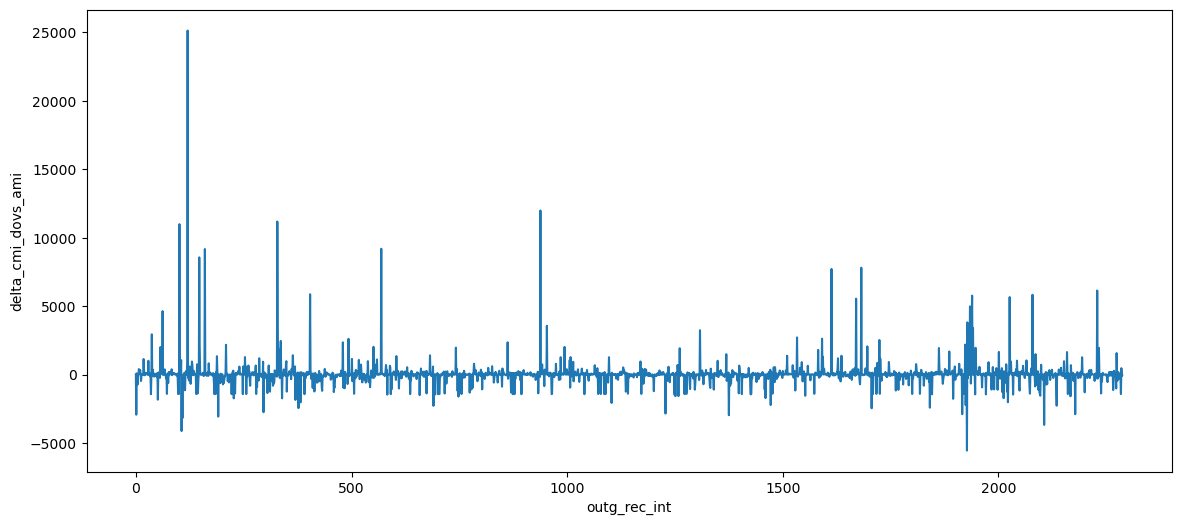

In [145]:
fig,ax = Plot_General.default_subplots()
sns.lineplot(ax=ax, x='outg_rec_int', y='delta_cmi_dovs_ami', data=summary_df)

<Axes: >

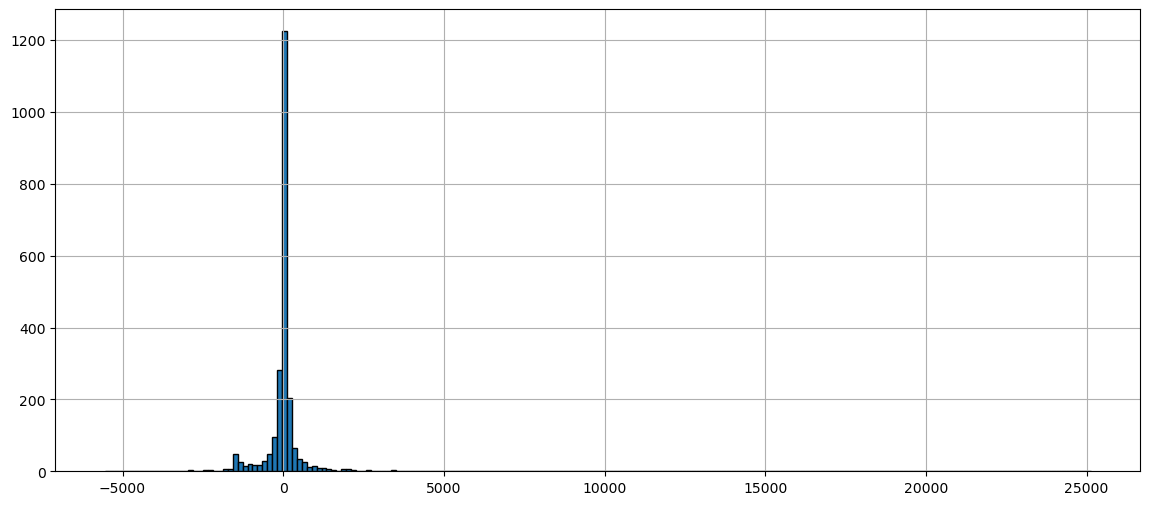

In [147]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='delta_cmi_dovs_ami', 
    min_max_and_bin_size=200
)

<Axes: >

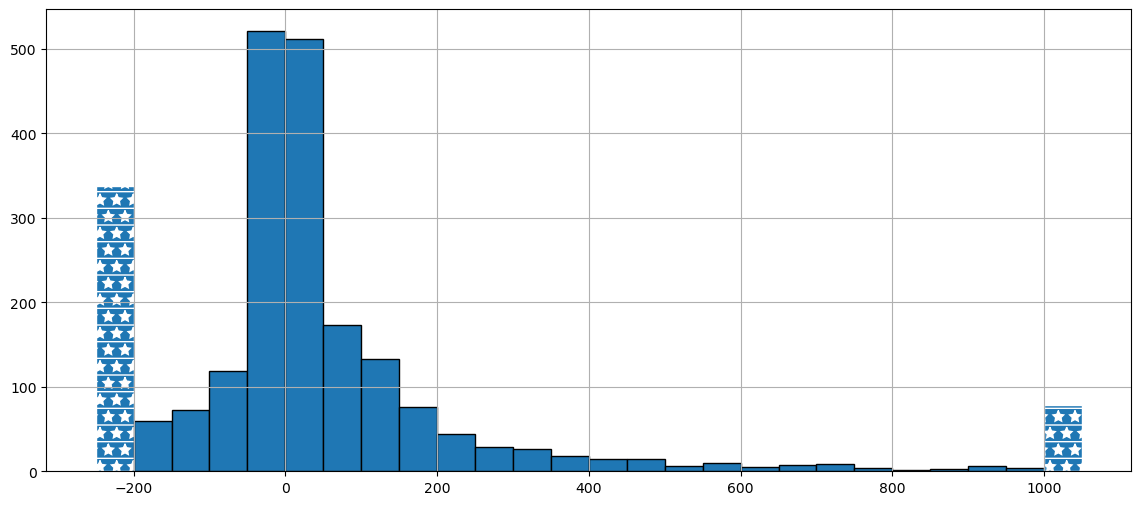

In [149]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='delta_cmi_dovs_ami', 
    min_max_and_bin_size=[-200, 1000, 50], 
    include_over_underflow=True
)

In [153]:
summary_df.describe()

,ci_dovs,ci_ami,ci_ami_dovs_beg,cmi_dovs,delta_ci_dovs_ami,delta_ci_dovs_ami_dovs_beg,outg_rec_int
count,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.00000
mean,11.573864,10.483392,10.434878,1498.412587,1.090472,1.138986,1143.50000
std,48.397826,48.065077,48.035206,7206.890985,5.567814,5.900123,660.63303
min,1.000000,0.000000,0.000000,6.000000,-11.000000,-11.000000,0.00000
25%,1.000000,1.000000,1.000000,123.750000,0.000000,0.000000,571.75000
50%,3.000000,2.000000,2.000000,304.000000,0.000000,0.000000,1143.50000
75%,9.000000,7.000000,7.000000,852.000000,1.000000,1.000000,1715.25000
max,1342.000000,1342.000000,1342.000000,232308.000000,162.000000,162.000000,2287.00000


In [155]:
summary_df = DOVSAudit.make_summary_df_cols_pretty(summary_df)

In [157]:
DOVSAudit.get_delta_cols_from_summary_df(summary_df).sum()

Delta CI DOVS vs AMI                         2495.0
Delta CMI DOVS vs AMI                  54760.860767
Delta CI DOVS vs AMI w/ DOVS Beg.            2606.0
Delta CMI DOVS vs AMI w/ DOVS Beg.    397754.827433
dtype: object

In [159]:
DOVSAudit.get_delta_cols_from_summary_df(summary_df).describe()

,Delta CI DOVS vs AMI,Delta CI DOVS vs AMI w/ DOVS Beg.
count,2288.000000,2288.000000
mean,1.090472,1.138986
std,5.567814,5.900123
min,-11.000000,-11.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,162.000000,162.000000


In [163]:
# fig_save_dir = r'C:\Users\s346557\Documents\Presentations\DOVS_check\Figures\forAmanda'

C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': '$\\Delta$CMI: DOVS vs AMI'}, xlabel='Outage', ylabel='$\\Delta$CMI'>

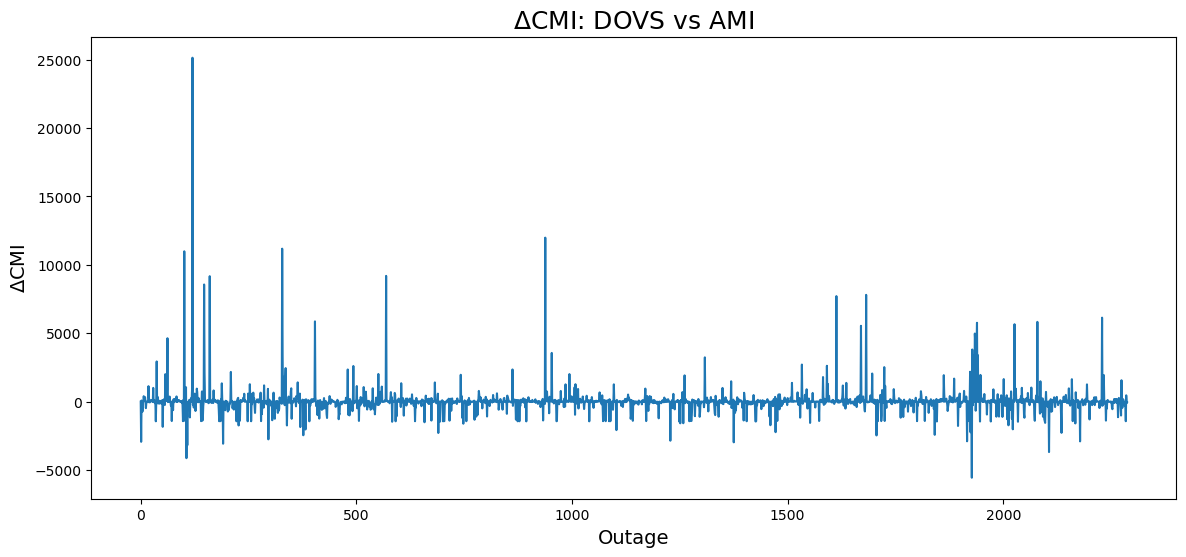

In [166]:
fig,ax = Plot_General.default_subplots()
sns.lineplot(ax=ax, x='outg_rec_int', y='Delta CMI DOVS vs AMI', data=summary_df)
Plot_General.set_general_plotting_args(
    ax,
    title_args=dict(label='$\Delta$CMI: DOVS vs AMI', fontsize=18),
    xlabel_args=dict(xlabel='Outage', fontsize=14), 
    ylabel_args=dict(ylabel='$\Delta$CMI', fontsize=14)
)
# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=fig_save_dir, 
#     save_name='DeltaCMI_vs_Outage_AMI.png', 
#     bbox_inches='tight'
# )

<Axes: >

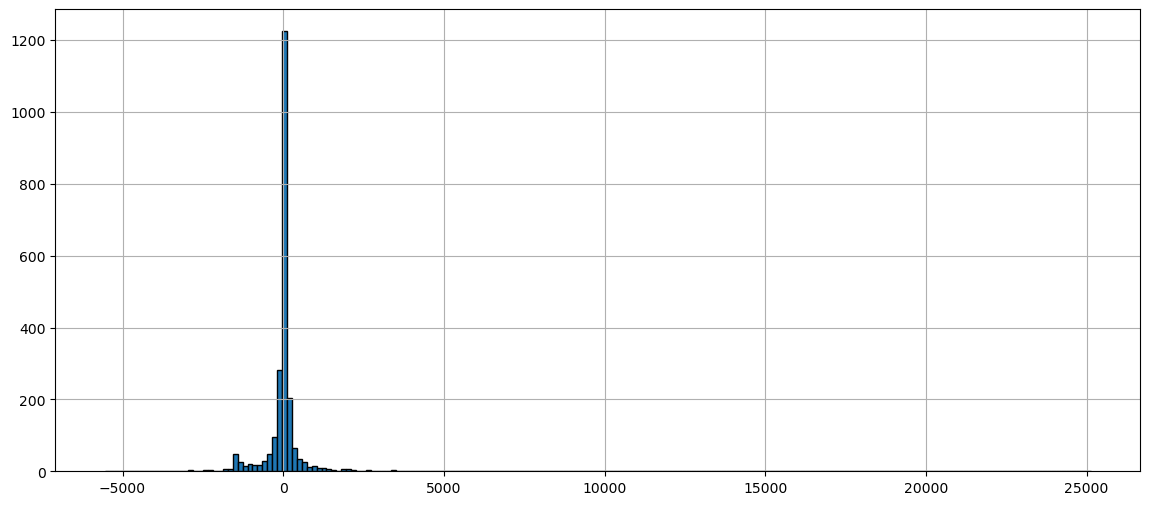

In [169]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='Delta CMI DOVS vs AMI', 
    min_max_and_bin_size=200
)

<Axes: title={'center': '$\\Delta$CMI: DOVS vs AMI'}, xlabel='$\\Delta$CMI', ylabel='Counts'>

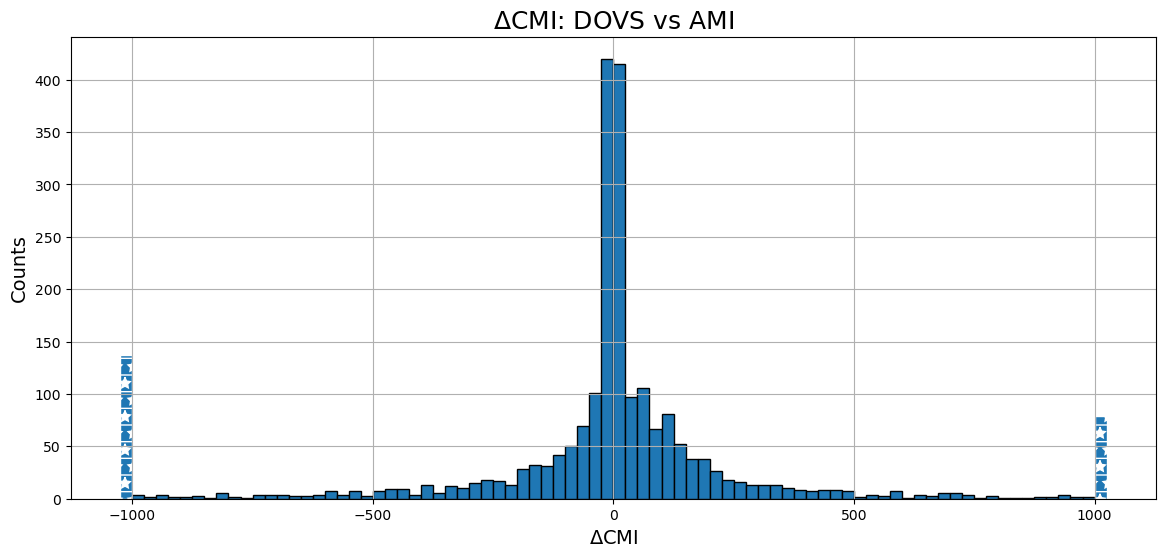

In [171]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='Delta CMI DOVS vs AMI', 
    min_max_and_bin_size=[-1000, 1000, 25], 
    include_over_underflow=True
)
Plot_General.set_general_plotting_args(
    ax,
    title_args=dict(label='$\Delta$CMI: DOVS vs AMI', fontsize=18),
    xlabel_args=dict(xlabel='$\Delta$CMI', fontsize=14), 
    ylabel_args=dict(ylabel='Counts', fontsize=14)
)

# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=fig_save_dir, 
#     save_name='DeltaCMI_DOVS_vs_AMI.png', 
#     bbox_inches='tight'
# )

<Axes: >

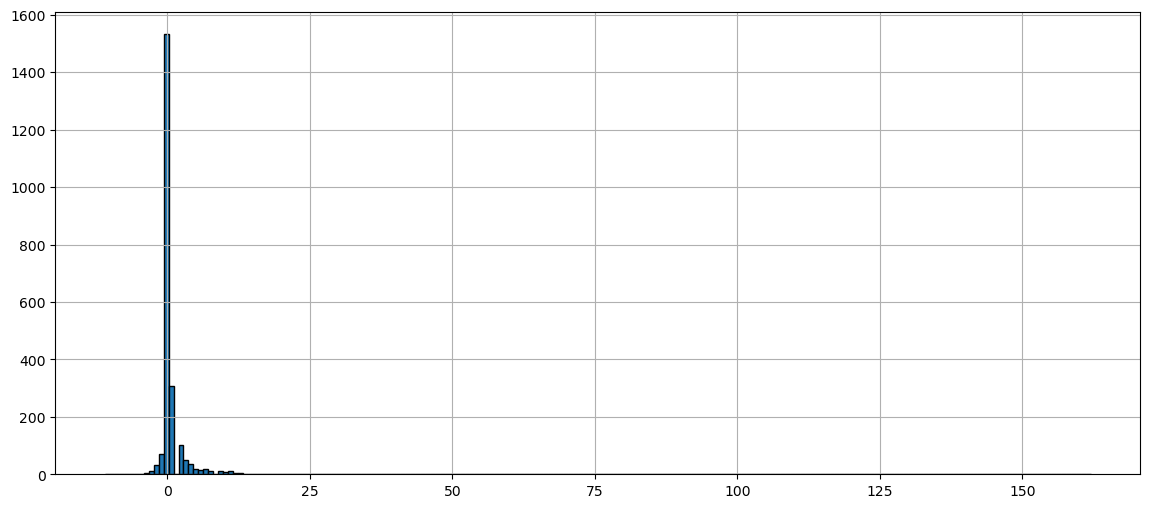

In [176]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='Delta CI DOVS vs AMI', 
    min_max_and_bin_size=200
)

<Axes: title={'center': '$\\Delta$CI: DOVS vs AMI'}, xlabel='$\\Delta$CI', ylabel='Counts'>

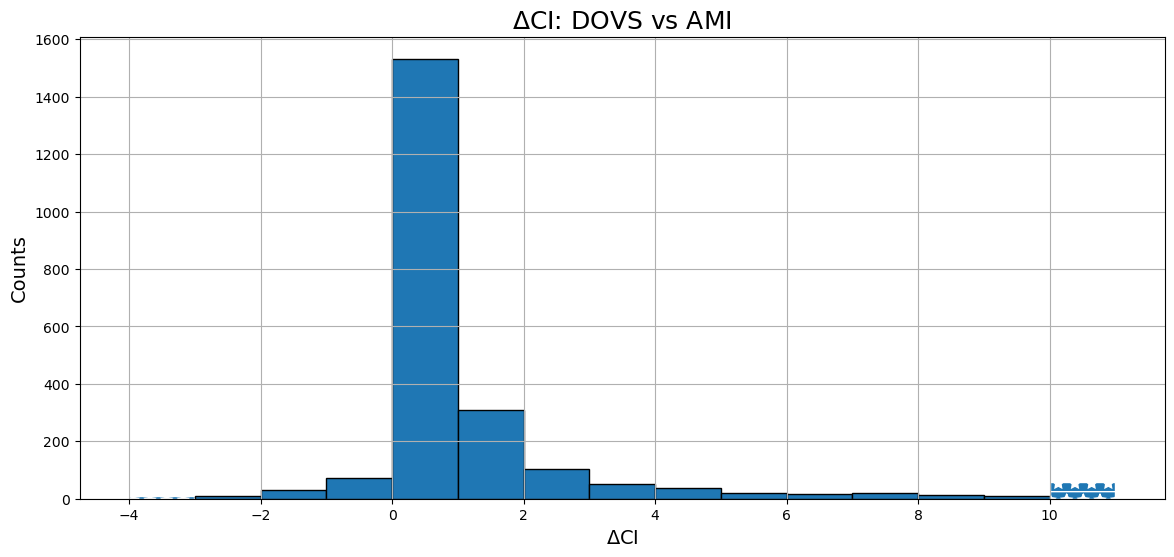

In [179]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='Delta CI DOVS vs AMI', 
    min_max_and_bin_size=[-3, 10, 1], 
    include_over_underflow=True
)
Plot_General.set_general_plotting_args(
    ax,
    title_args=dict(label='$\Delta$CI: DOVS vs AMI', fontsize=18),
    xlabel_args=dict(xlabel='$\Delta$CI', fontsize=14), 
    ylabel_args=dict(ylabel='Counts', fontsize=14)
)

# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=fig_save_dir, 
#     save_name='DeltaCI_DOVS_vs_AMI.png', 
#     bbox_inches='tight'
# )

In [181]:
summary_df['CI DOVS'].sum()

26481.0

In [183]:
summary_df['CMI DOVS'].sum()

3428368.0

In [188]:
print('----- summary_df -----')
print(f'shape[0] = {summary_df.shape[0]}')
print(summary_df[['CI DOVS', 'CMI DOVS']].sum())
print()
#-------------------------

----- summary_df -----
shape[0] = 2288
CI DOVS       26481.0
CMI DOVS    3428368.0
dtype: float64



In [190]:
summary_df['Pct. Delta CI DOVS vs AMI']  = 100.*summary_df['Delta CI DOVS vs AMI']/summary_df['CI DOVS']
summary_df['Pct. Delta CMI DOVS vs AMI'] = 100.*summary_df['Delta CMI DOVS vs AMI']/summary_df['CMI DOVS']
#-----
summary_df['Pct. Delta CI DOVS vs AMI w/ DOVS Beg.']  = 100.*summary_df['Delta CI DOVS vs AMI w/ DOVS Beg.']/summary_df['CI DOVS']
summary_df['Pct. Delta CMI DOVS vs AMI w/ DOVS Beg.'] = 100.*summary_df['Delta CMI DOVS vs AMI w/ DOVS Beg.']/summary_df['CMI DOVS']

C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='outg_rec_int', ylabel='Pct. Delta CMI DOVS vs AMI'>

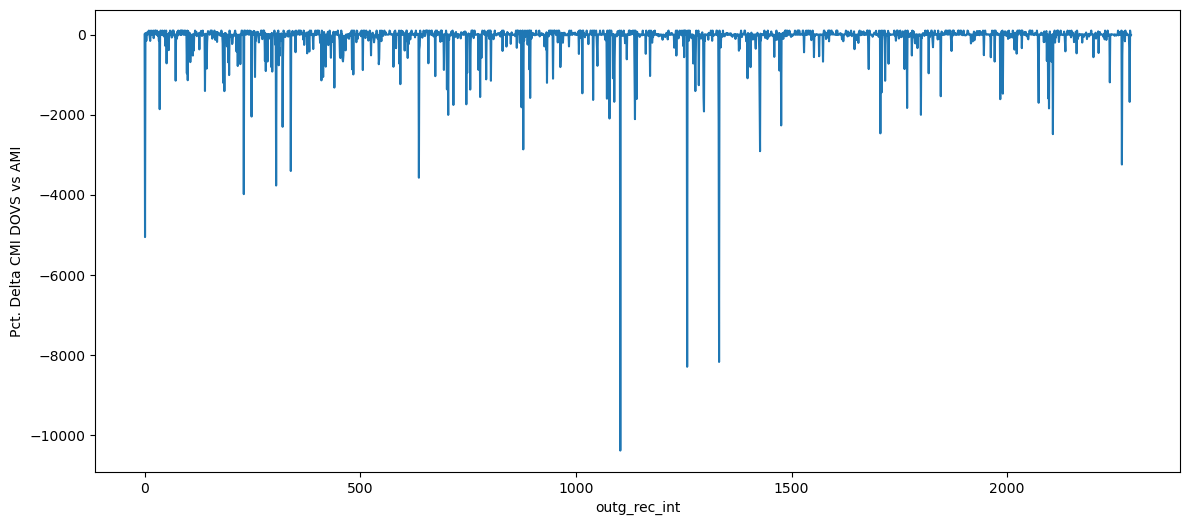

In [192]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
sns.lineplot(ax=ax, x='outg_rec_int', y='Pct. Delta CMI DOVS vs AMI', data=summary_df)

C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(-1000.0, 150.0)

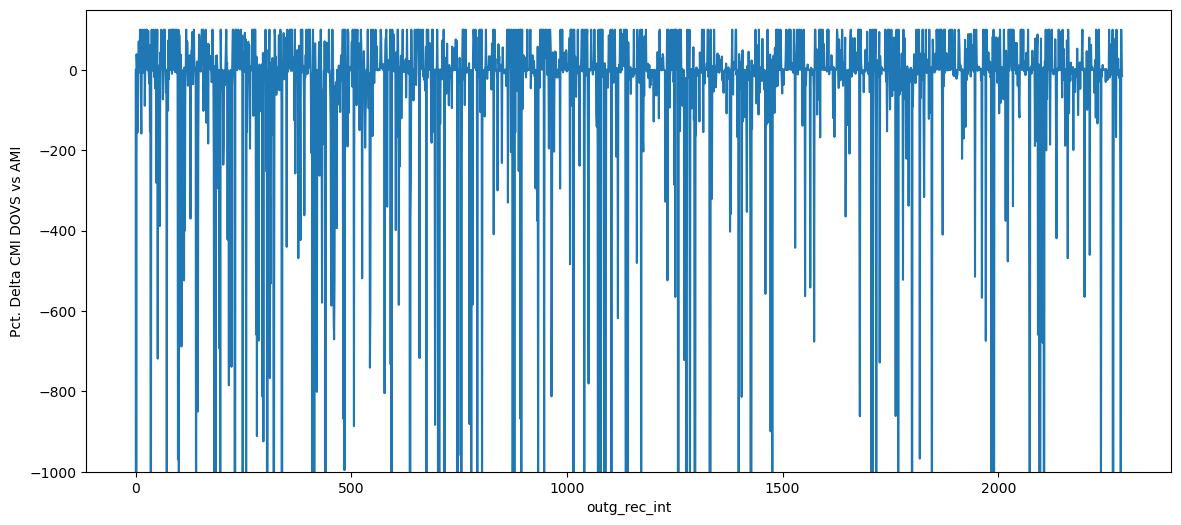

In [194]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
sns.lineplot(ax=ax, x='outg_rec_int', y='Pct. Delta CMI DOVS vs AMI', data=summary_df)
ax.set_ylim([-1000, 150])

C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='outg_rec_int', ylabel='Pct. Delta CI DOVS vs AMI'>

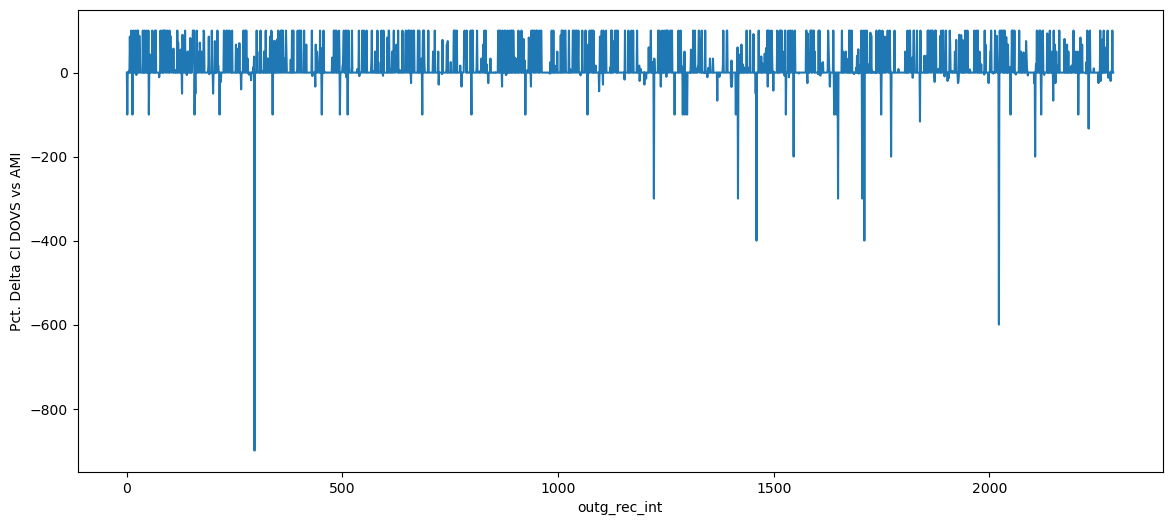

In [196]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
sns.lineplot(ax=ax, x='outg_rec_int', y='Pct. Delta CI DOVS vs AMI', data=summary_df)

C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='outg_rec_int', ylabel='Delta CMI DOVS vs AMI'>

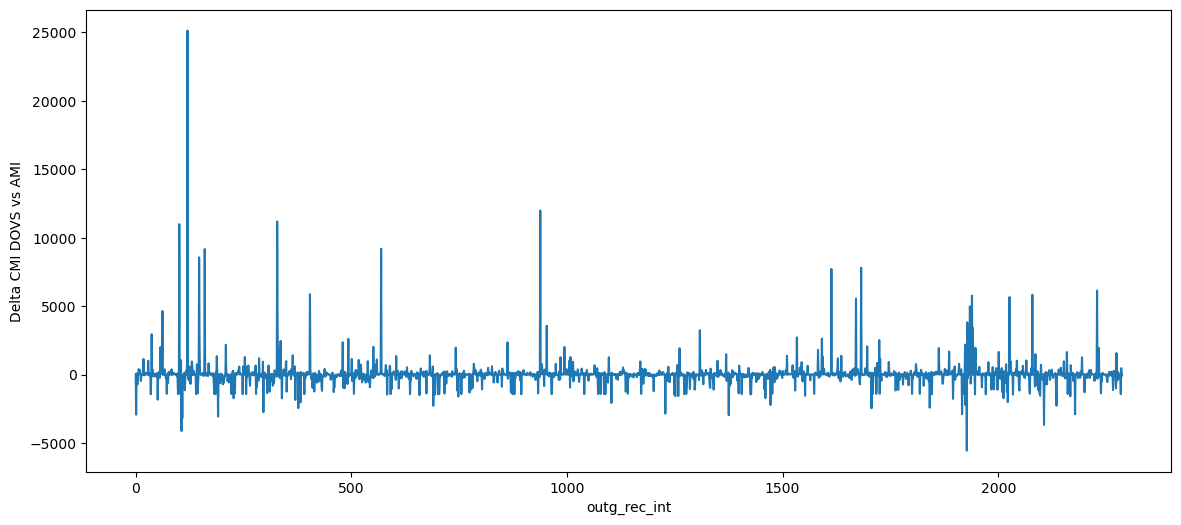

In [198]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
sns.lineplot(ax=ax, x='outg_rec_int', y='Delta CMI DOVS vs AMI', data=summary_df)

In [202]:
final_df_cmi = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = [
        [None, None], 
        [-10000, 10000], 
        [-1000, 1000], 
        [-100, 100], 
        [-10, 10], 
    ], 
    calc_col = 'Delta CMI DOVS vs AMI', 
    dovs_col = 'CMI DOVS', 
    subset_col = None, 
    metric = 'CMI', 
    are_limits_pct = False
)

In [205]:
final_df_cmi_pct = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = [
        [None, None], 
        [-100, 100], 
        [-50, 50], 
        [-20, 20], 
        [-10, 10], 
    ], 
    calc_col = 'Delta CMI DOVS vs AMI', 
    dovs_col = 'CMI DOVS', 
    subset_col = 'Pct. Delta CMI DOVS vs AMI', 
    metric = 'CMI', 
    are_limits_pct = True
)

In [208]:
final_df_ci = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = [
        [None, None], 
        [-50, 50], 
        [-25, 25], 
        [-10, 10], 
        [-5, 5], 
    ], 
    calc_col = 'Delta CI DOVS vs AMI', 
    dovs_col = 'CI DOVS', 
    subset_col = None, 
    metric = 'CI', 
    are_limits_pct = False
)

In [211]:
final_df_ci_pct = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = [
        [None, None], 
        [-100, 100], 
        [-50, 50], 
        [-20, 20], 
        [-10, 10], 
    ], 
    calc_col = 'Delta CI DOVS vs AMI', 
    dovs_col = 'CI DOVS', 
    subset_col = 'Pct. Delta CI DOVS vs AMI', 
    metric = 'CI', 
    are_limits_pct = True
)

In [214]:
# pdf = PdfPages(r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\SummaryPages_v2.pdf')
# pdf = PdfPages(r'C:\Users\s346557\Documents\LocalData\swp_LA_outgs\oh_OH.pdf')

In [216]:
summary_df

,outg_rec_nb,CI DOVS,CI AMI,CMI AMI w/ DOVS Beg.,CMI DOVS,CMI AMI,cmi_ami_dovs_beg,Delta CI DOVS vs AMI,Delta CMI DOVS vs AMI,Delta CI DOVS vs AMI w/ DOVS Beg.,Delta CMI DOVS vs AMI w/ DOVS Beg.,outg_rec_int,Pct. Delta CI DOVS vs AMI,Pct. Delta CMI DOVS vs AMI,Pct. Delta CI DOVS vs AMI w/ DOVS Beg.,Pct. Delta CMI DOVS vs AMI w/ DOVS Beg.
0,13832466,1.0,1.0,1.0,160.0,159.7,159.7,0.0,0.3,0.0,0.3,0,0.0,0.1875,0.0,0.1875
1,13832480,1.0,2.0,2.0,58.0,2994.083333,120.083333,-1.0,-2936.083333,-1.0,-62.083333,1,-100.0,-5062.212644,-100.0,-107.04023
2,13832514,2.0,2.0,2.0,216.0,131.866667,131.866667,0.0,84.133333,0.0,84.133333,2,0.0,38.950617,0.0,38.950617
3,13832472,4.0,4.0,4.0,1308.0,1313.95,1309.966667,0.0,-5.95,0.0,-1.966667,3,0.0,-0.454893,0.0,-0.150357
4,13832408,6.0,6.0,6.0,468.0,1197.433333,461.0,0.0,-729.433333,0.0,7.0,4,0.0,-155.861823,0.0,1.495726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,13947427,2.0,2.0,2.0,76.0,328.983333,87.866667,0.0,-252.983333,0.0,-11.866667,2283,0.0,-332.872807,0.0,-15.614035
1335,13947771,1.0,1.0,1.0,85.0,1515.3,85.3,0.0,-1430.3,0.0,-0.3,2284,0.0,-1682.705882,0.0,-0.352941
1336,13947695,7.0,0.0,0.0,462.0,0.0,0.0,7.0,462.0,7.0,462.0,2285,100.0,100.0,100.0,100.0
1337,13947735,5.0,5.0,5.0,1165.0,1277.883333,1166.683333,0.0,-112.883333,0.0,-1.683333,2286,0.0,-9.689557,0.0,-0.144492


# Full Algorithm: CMI with relative cuts

C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

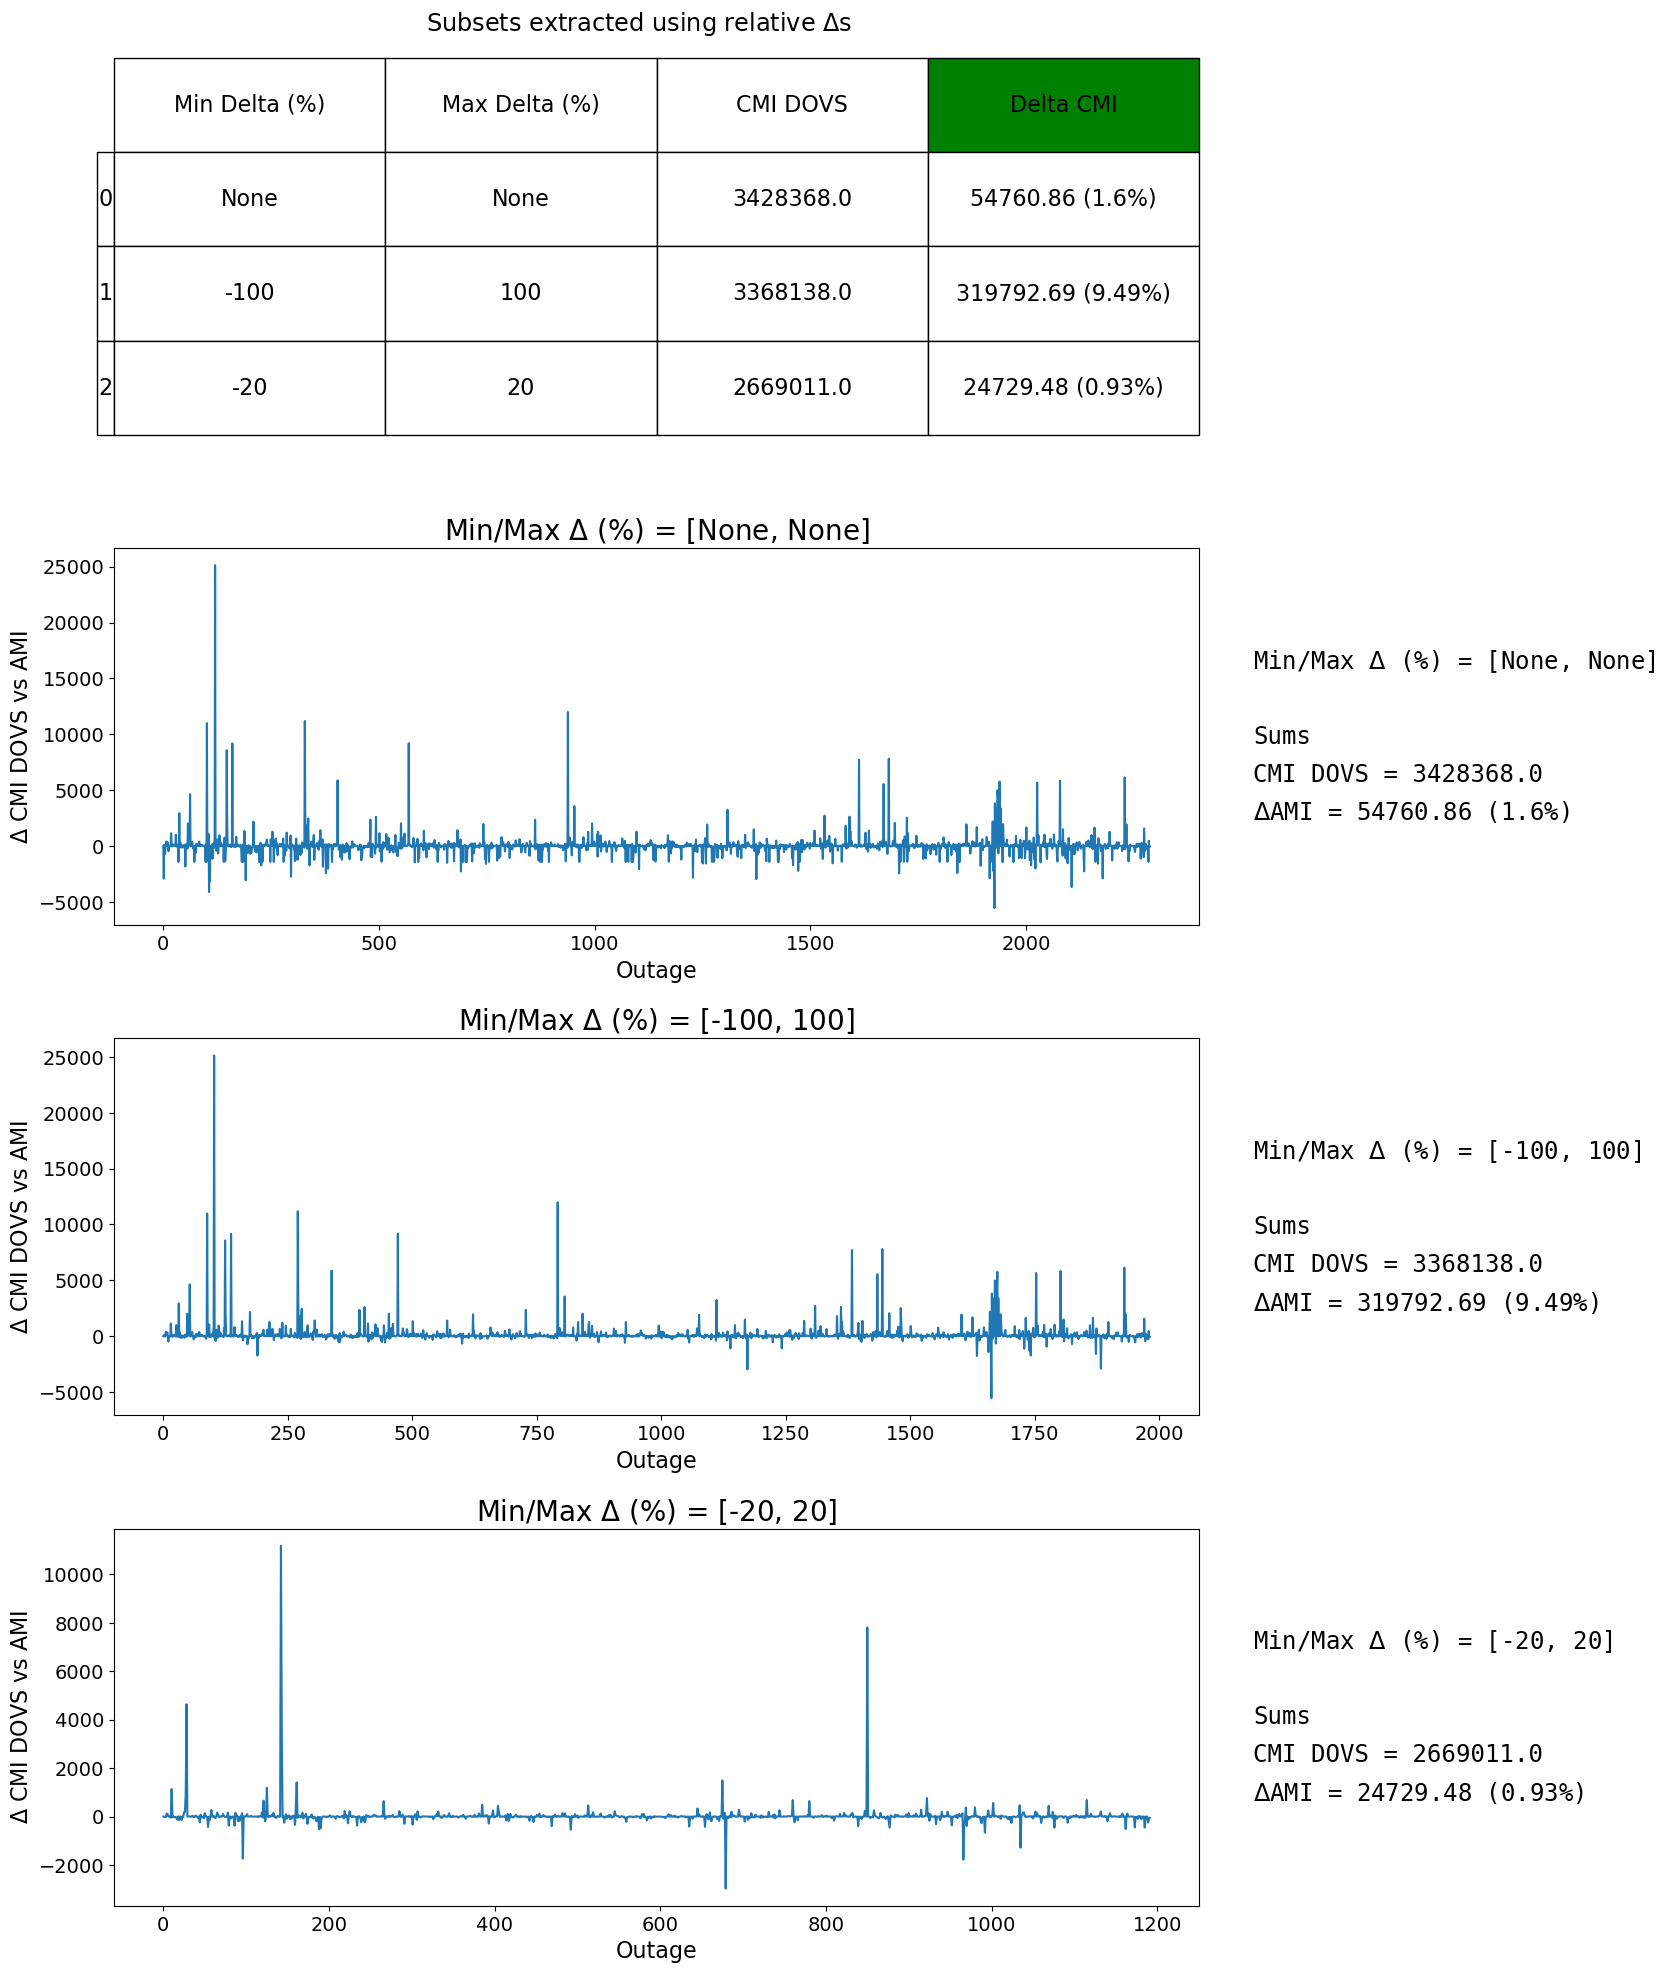

In [220]:
# limits_coll = [
#     [None, None], 
#     [-100, 100], 
#     [-50, 50], 
#     [-20, 20], 
#     [-10, 10],
# ]
limits_coll = [
    [None, None], 
    [-100, 100], 
    [-20, 20]
]

calc_col = 'Delta CMI DOVS vs AMI'
dovs_col = 'CMI DOVS'
subset_col = 'Pct. Delta CMI DOVS vs AMI'
metric='CMI'
are_limits_pct=True

#--------------------------------------------------
final_df = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

#--------------------------------------------------
fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll)+1)
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))
#-------------------------
axs[0].axis('off')
tbl = pd.plotting.table(
    axs[0], 
    final_df, 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green']
)
tbl.set_fontsize(16)
#-------------------------
for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i+1], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
#-------------------------
if are_limits_pct:
    fig.suptitle('Subsets extracted using relative $\Delta$s', y=0.90, fontsize='xx-large')
else:
    fig.suptitle('Subsets extracted using raw $\Delta$s', y=0.90, fontsize='xx-large')
    
# pdf.savefig(fig, bbox_inches='tight')

# Full Algorithm: CMI with raw cuts

C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\s346557\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

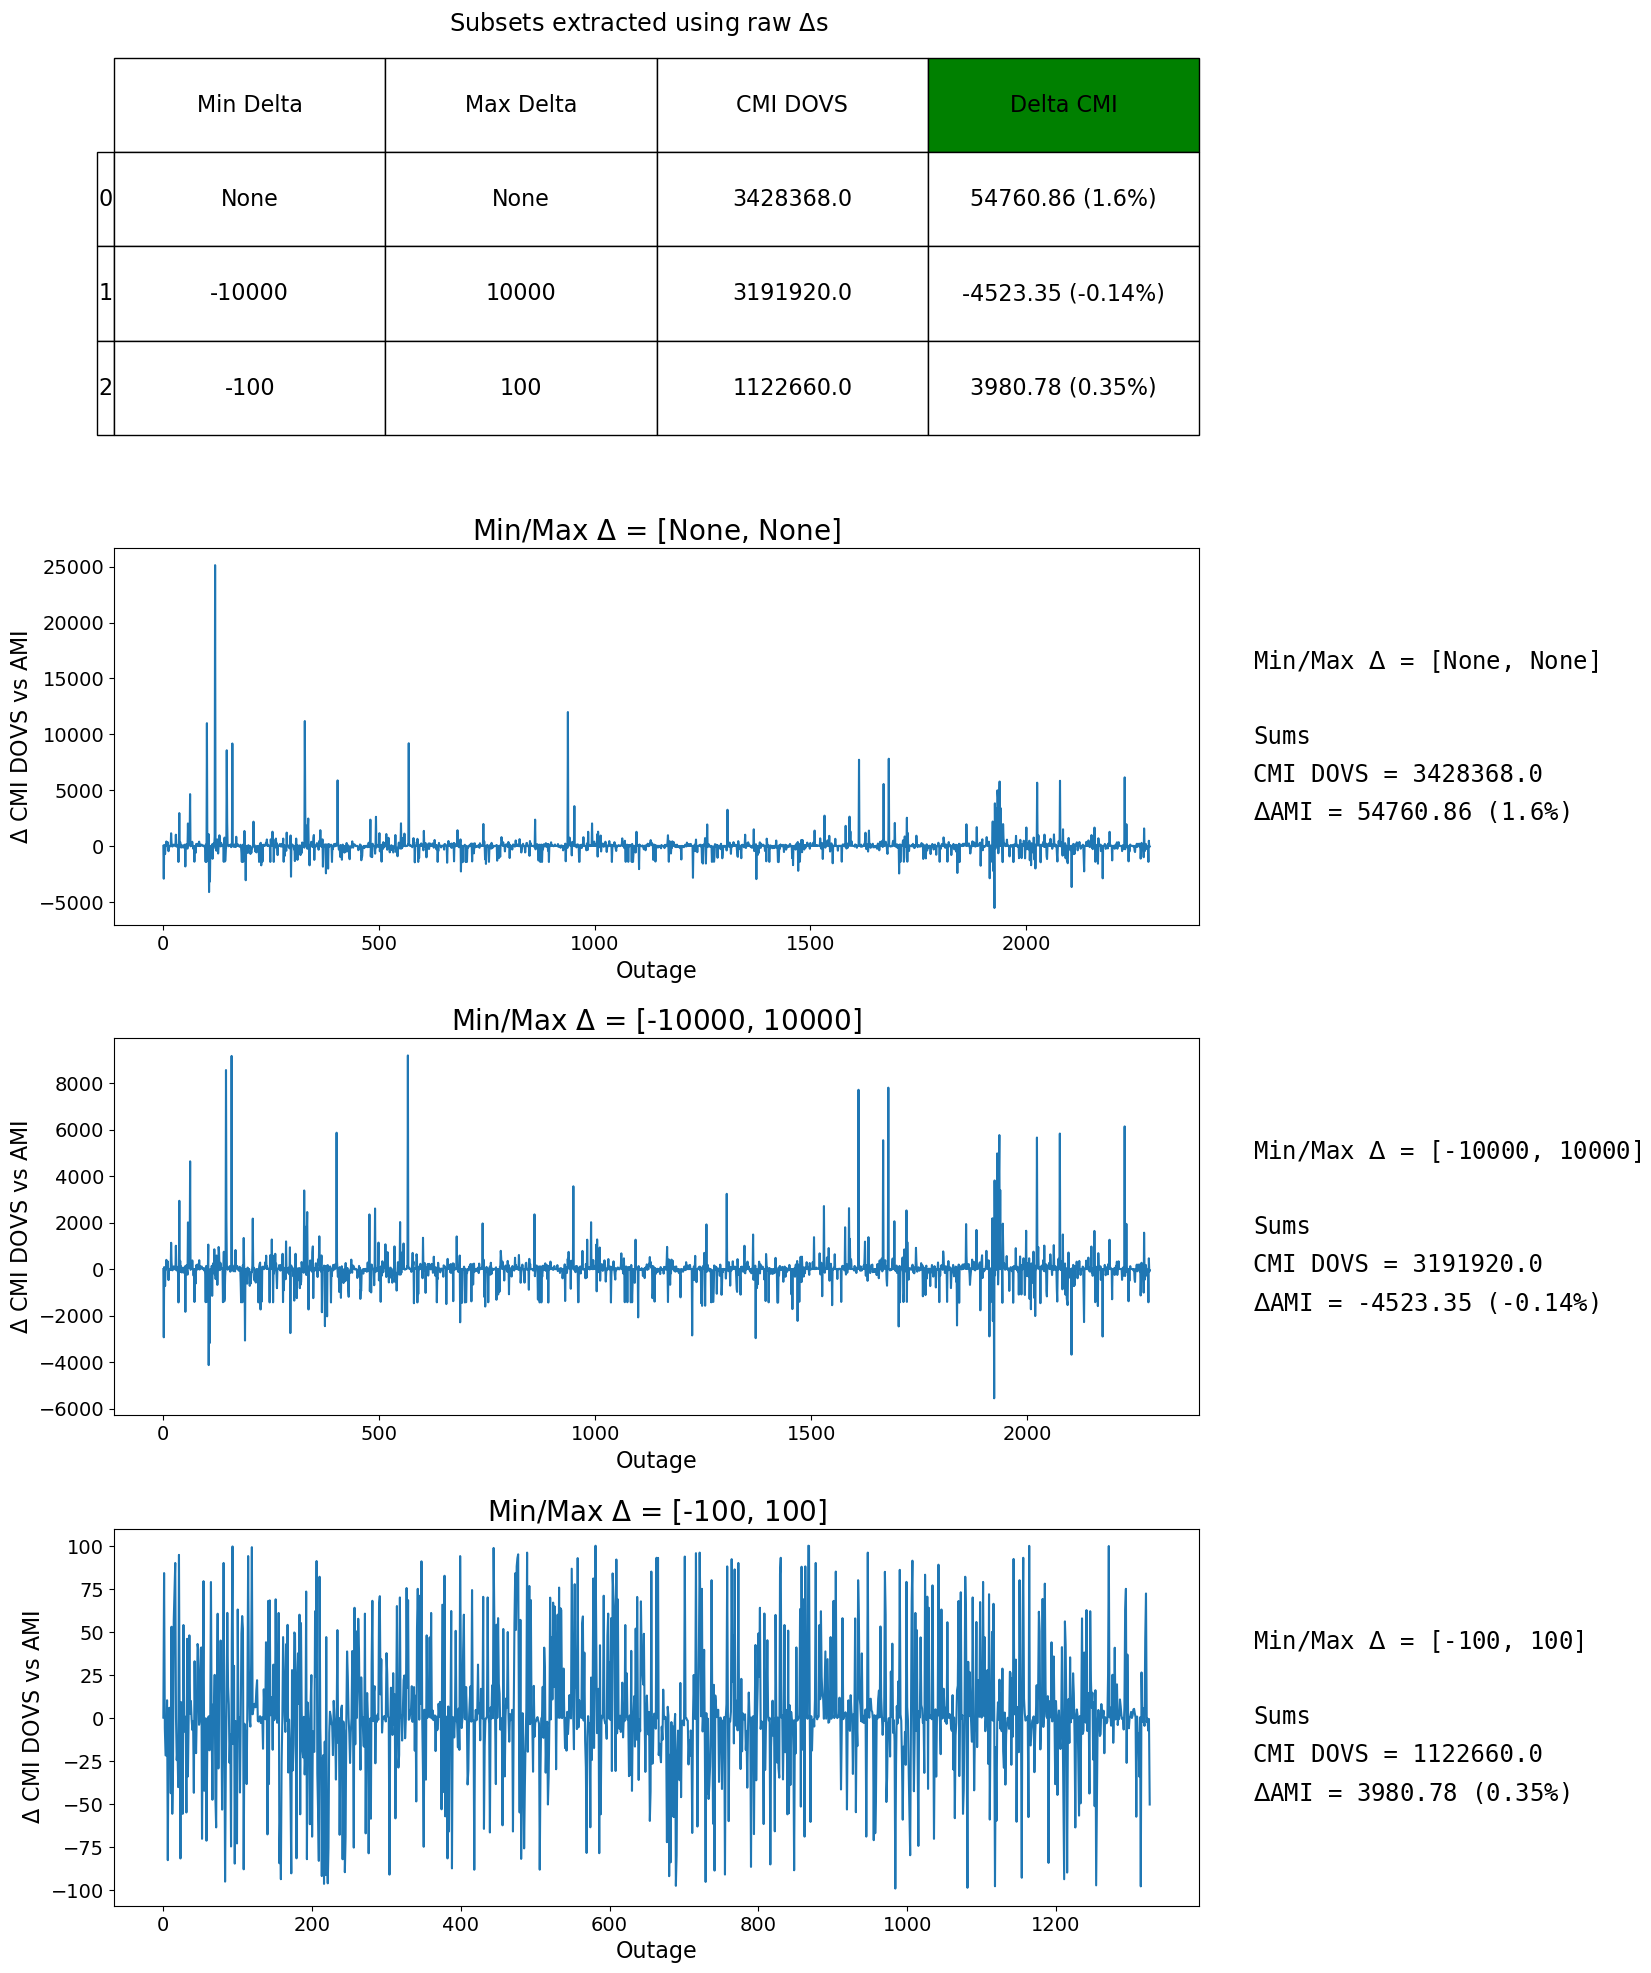

In [224]:
limits_coll = [
    [None, None], 
    [-10000, 10000], 
    [-100, 100]
]

calc_col = 'Delta CMI DOVS vs AMI'
dovs_col='CMI DOVS'
subset_col=None
metric='CMI'
are_limits_pct=False

#--------------------------------------------------
final_df = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

#--------------------------------------------------
fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll)+1)
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))
#-------------------------
axs[0].axis('off')
tbl = pd.plotting.table(
    axs[0], 
    final_df, 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green']
)
tbl.set_fontsize(16)
#-------------------------
for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i+1], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
#-------------------------
if are_limits_pct:
    fig.suptitle('Subsets extracted using relative $\Delta$s', y=0.90, fontsize='xx-large')
else:
    fig.suptitle('Subsets extracted using raw $\Delta$s', y=0.90, fontsize='xx-large')
    
# pdf.savefig(fig, bbox_inches='tight')

In [225]:
# pdf.close()

# DOVS Beg.: CMI with relative cuts

In [ ]:
# limits_coll = [
#     [None, None], 
#     [-100, 100], 
#     [-50, 50], 
#     [-20, 20], 
#     [-10, 10],
# ]
limits_coll = [
    [None, None], 
    [-100, 100], 
    [-20, 20]
]

calc_col = 'Delta CMI DOVS vs AMI w/ DOVS Beg.'
dovs_col = 'CMI DOVS'
subset_col = 'Pct. Delta CMI DOVS vs AMI w/ DOVS Beg.'
metric='CMI'
are_limits_pct=True

#--------------------------------------------------
final_df = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

#--------------------------------------------------
fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll)+1)
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))
#-------------------------
axs[0].axis('off')
tbl = pd.plotting.table(
    axs[0], 
    final_df, 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green']
)
tbl.set_fontsize(16)
#-------------------------
for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i+1], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
#-------------------------
if are_limits_pct:
    fig.suptitle('Subsets extracted using relative $\Delta$s', y=0.90, fontsize='xx-large')
else:
    fig.suptitle('Subsets extracted using raw $\Delta$s', y=0.90, fontsize='xx-large')
    
# pdf.savefig(fig, bbox_inches='tight')

# DOVS Beg.: CMI with raw cuts

In [ ]:
limits_coll = [
    [None, None], 
    [-10000, 10000], 
    [-100, 100]
]

calc_col = 'Delta CMI DOVS vs AMI w/ DOVS Beg.'
dovs_col='CMI DOVS'
subset_col=None
metric='CMI'
are_limits_pct=False

#--------------------------------------------------
final_df = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

#--------------------------------------------------
fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll)+1)
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))
#-------------------------
axs[0].axis('off')
tbl = pd.plotting.table(
    axs[0], 
    final_df, 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green']
)
tbl.set_fontsize(16)
#-------------------------
for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i+1], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
#-------------------------
if are_limits_pct:
    fig.suptitle('Subsets extracted using relative $\Delta$s', y=0.90, fontsize='xx-large')
else:
    fig.suptitle('Subsets extracted using raw $\Delta$s', y=0.90, fontsize='xx-large')
    
# pdf.savefig(fig, bbox_inches='tight')

# Full Algorithm: CI with relative cuts

In [ ]:
limits_coll = [
    [None, None], 
    [-100, 100], 
    [-20, 20]
]

calc_col = 'Delta CI DOVS vs AMI'
dovs_col = 'CI DOVS'
subset_col = 'Pct. Delta CI DOVS vs AMI'
metric='CI'
are_limits_pct=True

#--------------------------------------------------
final_df = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

#--------------------------------------------------
fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll)+1)
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))
#-------------------------
axs[0].axis('off')
tbl = pd.plotting.table(
    axs[0], 
    final_df, 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green']
)
tbl.set_fontsize(16)
#-------------------------
for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i+1], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
#-------------------------
if are_limits_pct:
    fig.suptitle('Subsets extracted using relative $\Delta$s', y=0.90, fontsize='xx-large')
else:
    fig.suptitle('Subsets extracted using raw $\Delta$s', y=0.90, fontsize='xx-large')
    
# pdf.savefig(fig, bbox_inches='tight')

# Full Algorithm: CI with raw cuts

In [ ]:
limits_coll = [
    [None, None], 
    [-50, 50], 
    [-10, 10]
]


calc_col = 'Delta CI DOVS vs AMI'
dovs_col='CI DOVS'
subset_col=None
metric='CI'
are_limits_pct=False

#--------------------------------------------------
final_df = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

#--------------------------------------------------
fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll)+1)
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))
#-------------------------
axs[0].axis('off')
tbl = pd.plotting.table(
    axs[0], 
    final_df, 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green']
)
tbl.set_fontsize(16)
#-------------------------
for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i+1], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
#-------------------------
if are_limits_pct:
    fig.suptitle('Subsets extracted using relative $\Delta$s', y=0.90, fontsize='xx-large')
else:
    fig.suptitle('Subsets extracted using raw $\Delta$s', y=0.90, fontsize='xx-large')
    
# pdf.savefig(fig, bbox_inches='tight')

# DOVS Beg.: CI with relative cuts

In [ ]:
limits_coll = [
    [None, None], 
    [-100, 100], 
    [-20, 20]
]

calc_col = 'Delta CI DOVS vs AMI w/ DOVS Beg.'
dovs_col = 'CI DOVS'
subset_col = 'Pct. Delta CI DOVS vs AMI w/ DOVS Beg.'
metric='CI'
are_limits_pct=True

#--------------------------------------------------
final_df = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

#--------------------------------------------------
fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll)+1)
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))
#-------------------------
axs[0].axis('off')
tbl = pd.plotting.table(
    axs[0], 
    final_df, 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green']
)
tbl.set_fontsize(16)
#-------------------------
for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i+1], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
#-------------------------
if are_limits_pct:
    fig.suptitle('Subsets extracted using relative $\Delta$s', y=0.90, fontsize='xx-large')
else:
    fig.suptitle('Subsets extracted using raw $\Delta$s', y=0.90, fontsize='xx-large')
    
# pdf.savefig(fig, bbox_inches='tight')

# DOVS Beg.: CI with raw cuts

In [ ]:
limits_coll = [
    [None, None], 
    [-50, 50], 
    [-10, 10]
]


calc_col = 'Delta CI DOVS vs AMI w/ DOVS Beg.'
dovs_col='CI DOVS'
subset_col=None
metric='CI'
are_limits_pct=False

#--------------------------------------------------
final_df = DOVSAudit.build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

#--------------------------------------------------
fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll)+1)
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))
#-------------------------
axs[0].axis('off')
tbl = pd.plotting.table(
    axs[0], 
    final_df, 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green']
)
tbl.set_fontsize(16)
#-------------------------
for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i+1], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
#-------------------------
if are_limits_pct:
    fig.suptitle('Subsets extracted using relative $\Delta$s', y=0.90, fontsize='xx-large')
else:
    fig.suptitle('Subsets extracted using raw $\Delta$s', y=0.90, fontsize='xx-large')
    
# pdf.savefig(fig, bbox_inches='tight')

# FOR PEGGY

In [ ]:
def build_final_summary_results(
    summary_df, 
    limits_coll, 
    calc_col, 
    dovs_col, 
    subset_col, 
    metric, 
    are_limits_pct, 
    assert_cols_seem_approp=True
):
    r"""
    e.g.:
            final_df_cmi = DOVSAudit.build_final_summary_results(
                summary_df=summary_df, 
                limits_coll = [
                    [None, None], 
                    [-10000, 10000], 
                    [-1000, 1000], 
                    [-100, 100], 
                    [-10, 10], 
                ], 
                calc_col = 'Delta CMI DOVS vs AMI', 
                dovs_col = 'CMI DOVS', 
                subset_col = None, 
                metric = 'CMI', 
                are_limits_pct = False
            )
    """
    #-------------------------
    assert(metric.upper() in ['CI', 'CMI'])
    metric=metric.upper()
    #-------------------------
    if subset_col is None:
        subset_col = calc_col
    #-------------------------
    if metric not in calc_col.upper():
        print(f"Warning: metric={metric} not found in calc_col={calc_col}")
        if assert_cols_seem_approp:
            assert(0)
    #-----
    if metric not in dovs_col.upper():
        print(f"Warning: metric={metric} not found in dovs_col={dovs_col}")
        if assert_cols_seem_approp:
            assert(0)    
    #-----
    if metric not in subset_col.upper():
        print(f"Warning: metric={metric} not found in subset_col={subset_col}")
        if assert_cols_seem_approp:
            assert(0)    
    #-------------------------
    min_delta_col = 'Min Delta'
    max_delta_col = 'Max Delta'
    delta_col = f'Delta {metric}'
    if are_limits_pct:
        min_delta_col = 'Min Delta (%)'
        max_delta_col = 'Max Delta (%)'
    #-----
    return_df = pd.DataFrame(columns=[
        min_delta_col, 
        max_delta_col, 
        dovs_col,  
        delta_col
    ])
    #-------------------------
    for i,limits_i in enumerate(limits_coll):
        summary_df_i = DOVSAudit.get_summary_df_subset(
            df=summary_df,
            cols=subset_col,
            min_val=limits_i[0],
            max_val=limits_i[1]
        )
        #------------------------------------
        return_df = pd.concat([
            return_df, 
            pd.DataFrame(
                {
                    min_delta_col: f"{limits_i[0]}", 
                    max_delta_col: f"{limits_i[1]}", 
                    dovs_col: f"{int(summary_df_i[dovs_col].sum())}",  
                    delta_col: f"{int(summary_df_i[calc_col].sum())} ({np.round(100*summary_df_i[calc_col].sum()/summary_df_i[dovs_col].sum(), decimals=1)}%)",  
                }, 
                index=[return_df.shape[0]]
            )
        ])
    #-------------------------
    return return_df

# DOVS Beg.: CMI with relative cuts

In [ ]:
# limits_coll = [
#     [None, None], 
#     [-100, 100], 
#     [-50, 50], 
#     [-20, 20], 
#     [-10, 10],
# ]
limits_coll = [
    [None, None], 
    [-100, 100], 
    [-20, 20]
]

calc_col = 'Delta CMI DOVS vs AMI w/ DOVS Beg.'
dovs_col = 'CMI DOVS'
subset_col = 'Pct. Delta CMI DOVS vs AMI w/ DOVS Beg.'
metric='CMI'
are_limits_pct=True

#--------------------------------------------------
final_df_1 = build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

# DOVS Beg.: CI with relative cuts

In [ ]:
limits_coll = [
    [None, None], 
    [-100, 100], 
    [-20, 20]
]

calc_col = 'Delta CI DOVS vs AMI w/ DOVS Beg.'
dovs_col = 'CI DOVS'
subset_col = 'Pct. Delta CI DOVS vs AMI w/ DOVS Beg.'
metric='CI'
are_limits_pct=True

#--------------------------------------------------
final_df_2 = build_final_summary_results(
    summary_df=summary_df, 
    limits_coll = limits_coll, 
    calc_col = calc_col, 
    dovs_col = dovs_col, 
    subset_col = subset_col, 
    metric = metric, 
    are_limits_pct = are_limits_pct
)

In [ ]:
final_df = pd.merge(
    final_df_1, 
    final_df_2, 
    left_on=['Min Delta (%)', 'Max Delta (%)'], 
    right_on=['Min Delta (%)', 'Max Delta (%)'], 
    how='inner'
)

In [ ]:
final_df

In [ ]:
# final_df[['Min Delta (%)', 'Max Delta (%)', 'CI DOVS', 'CMI DOVS', 'Delta CI', 'Delta CMI']]

In [ ]:
fig, ax = Plot_General.default_subplots(n_x=1, n_y=1)
ax.axis('off')
tbl = pd.plotting.table(
    ax, 
    final_df.iloc[:2], 
    cellLoc = 'center', 
    rowLoc = 'center', 
    bbox=[0,0,1,1], 
    colColours=['white', 'white', 'white', 'green', 'white', 'green']
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
#-----
Plot_General.save_fig(
    fig = fig, 
    save_dir = r'C:\Users\s346557\Documents\Presentations\ForPeggy_Nov2023', 
    save_name = 'Summary.png'
)

In [ ]:
summary_df['outg_rec_nb'].nunique()

In [ ]:
# pdf.close()

In [ ]:
import PyPDF2
import pdfrw
import pagelabels

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!
# NOTE: Last time I ran, PyPDF2.PdfWriter messed up text in images, but
#       pypdf.PdfMerger seemed to work well

#--------------------------------------------------
# First, write merged PDF file
pdfs = [
    r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\FinalDeliverableContents.pdf', 
    r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\SummaryPages.pdf', 
    r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\Results_ede_only.pdf'
]
merger = PyPDF2.PdfWriter()
for pdf in pdfs:
    merger.append(pdf)

merger.write(r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\DOVSCorrection_forAmanda.pdf')
merger.close()
#--------------------------------------------------
# Next, change the pages from FinalDeliverableContents to be numbered with Roman numerals
n_pages_contents_desc = len(PyPDF2.PdfReader(r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\FinalDeliverableContents.pdf').pages)
#-----
roman_labels = pagelabels.PageLabelScheme(
    startpage=0, # the index of the page of the PDF where the labels will start
    style="roman lowercase", # See options in PageLabelScheme.styles()
    prefix="",
    firstpagenum=1 # number to attribute to the first page of this index
)
reg_labels = pagelabels.PageLabelScheme(
    startpage=n_pages_contents_desc, 
    style="arabic", 
    prefix="",
    firstpagenum=1 
)
#-----
reader = PdfReader(r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\DOVSCorrection_forAmanda.pdf')
labels = pagelabels.PageLabels.from_pdf(reader)
labels.append(roman_labels) 
labels.append(reg_labels)
#-----
labels.write(reader)
writer = pdfrw.PdfWriter()
writer.trailer = reader
writer.write(r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\DOVSCorrection_forAmanda.pdf')

In [ ]:
limits_coll = [
    [None, None], 
    [-100, 100], 
    [-50, 50], 
    [-20, 20], 
    [-10, 10], 
]

calc_col = 'Delta CI DOVS vs AMI'
dovs_col='CI DOVS'
subset_col = 'Pct. Delta CI DOVS vs AMI'
metric='CI'
are_limits_pct=True


fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll))
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))

for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )

In [ ]:
limits_coll = [
    [None, None], 
    [-10000, 10000], 
    [-1000, 1000], 
    [-100, 100], 
    [-10, 10], 
]

calc_col = 'Delta CMI DOVS vs AMI'
dovs_col='CMI DOVS'
subset_col=None
metric='CMI'
are_limits_pct=False


fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll))
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))

for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
    


In [ ]:
limits_coll = [
    [None, None], 
    [-100, 100], 
    [-50, 50], 
    [-20, 20], 
    [-10, 10], 
]

calc_col = 'Delta CMI DOVS vs AMI'
dovs_col='CMI DOVS'
subset_col = 'Pct. Delta CMI DOVS vs AMI'
metric='CMI'
are_limits_pct=True


fig, axs = Plot_General.default_subplots(n_x=1, n_y=len(limits_coll))
Plot_General.adjust_subplots_args(fig, **Plot_General.get_subplots_adjust_args(hspace=0.30))

for i,ci_limits in enumerate(limits_coll):
    DOVSAudit.draw_delta_vs_outg_rec_int(
        ax=axs[i], 
        summary_df=summary_df, 
        limits=ci_limits, 
        calc_col=calc_col, 
        dovs_col=dovs_col, 
        subset_col=subset_col, 
        metric=metric, 
        are_limits_pct=are_limits_pct
    )
    


In [ ]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='Delta CMI DOVS vs AMI', 
    min_max_and_bin_size=200
)

In [ ]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='Delta CMI DOVS vs AMI', 
    min_max_and_bin_size=[-500, 1000, 50], 
    include_over_underflow=True
)
Plot_General.set_general_plotting_args(
    ax,
    title_args=dict(label='$\Delta$CMI: DOVS vs AMI', fontsize=18),
    xlabel_args=dict(xlabel='$\Delta$CMI', fontsize=14), 
    ylabel_args=dict(ylabel='Counts', fontsize=14)
)

# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=fig_save_dir, 
#     save_name='DeltaCMI_DOVS_vs_AMI.png', 
#     bbox_inches='tight'
# )

In [ ]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='Delta CI DOVS vs AMI', 
    min_max_and_bin_size=200
)

In [ ]:
fig,ax = Plot_General.default_subplots()
Plot_Hist.plot_hist(
    ax=ax, 
    df=summary_df, 
    x_col='Delta CI DOVS vs AMI', 
    min_max_and_bin_size=[-10, 25, 1], 
    include_over_underflow=True
)
Plot_General.set_general_plotting_args(
    ax,
    title_args=dict(label='$\Delta$CI: DOVS vs AMI', fontsize=18),
    xlabel_args=dict(xlabel='$\Delta$CI', fontsize=14), 
    ylabel_args=dict(ylabel='Counts', fontsize=14)
)

# Plot_General.save_fig(
#     fig=fig, 
#     save_dir=fig_save_dir, 
#     save_name='DeltaCI_DOVS_vs_AMI.png', 
#     bbox_inches='tight'
# )

In [ ]:
df_Wed0913   = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Wed0913\AllOPCOs\Results\detailed_summary.pkl')
df_Thurs0914 = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Thurs0914\AllOPCOs\Results\detailed_summary.pkl')
df_Fri0915   = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Fri0915\AllOPCOs\Results\detailed_summary.pkl')
df_Sun0917   = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Sun0917\AllOPCOs\Results\detailed_summary.pkl')
df_Tues0919  = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Tues0919\AllOPCOs\Results\detailed_summary.pkl')

In [ ]:
print(df_Wed0913.index.get_level_values(1).nunique())
print(df_Thurs0914.index.get_level_values(1).nunique())
print(df_Fri0915.index.get_level_values(1).nunique())
print(df_Sun0917.index.get_level_values(1).nunique())
print(df_Tues0919.index.get_level_values(1).nunique())

In [ ]:
df_Wed0913   = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Wed0913\AllOPCOs\df_outage.pkl')
df_Thurs0914 = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Thurs0914\AllOPCOs\df_outage.pkl')
df_Fri0915   = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Fri0915\AllOPCOs\df_outage.pkl')
df_Sun0917   = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Sun0917\AllOPCOs\df_outage.pkl')
df_Tues0919  = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230903_20230909_Tues0919\AllOPCOs\df_outage.pkl')

In [ ]:
print(df_Wed0913['OUTG_REC_NB'].nunique())
print(df_Thurs0914['OUTG_REC_NB'].nunique())
print(df_Fri0915['OUTG_REC_NB'].nunique())
print(df_Sun0917['OUTG_REC_NB'].nunique())
print(df_Tues0919['OUTG_REC_NB'].nunique())

In [ ]:
df1 = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230910_20230916_Wed0920\AllOPCOs\df_outage.pkl')
df2 = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230910_20230916_Tues0926\AllOPCOs\df_outage.pkl')
df3 = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230910_20230916_Fri0929\AllOPCOs\df_outage.pkl')

In [ ]:
print(df1['OUTG_REC_NB'].nunique())
print(df2['OUTG_REC_NB'].nunique())
print(df3['OUTG_REC_NB'].nunique())

In [ ]:
# df  = pd.read_pickle(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230910_20230916_Fri0929\AllOPCOs\Results\detailed_summary_dovs_beg.pkl')
# df.to_csv(r'C:\Users\s346557\Documents\LocalData\dovs_check\20230910_20230916_Fri0929\AllOPCOs\Results\detailed_summary_dovs_beg.csv')